In [1]:
import sys
import h5py
import numpy as np

# from cartopy import crs as ccrs
# from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter 

from matplotlib import colors as cm
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import sys
import os
import importlib.util

## Loading DATA

In [2]:
# parameters 
PR               = 0
level_index      = 5
file_path        = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"


# define variables
lat              = np.linspace(-90, 90, 64)
lat_cond         = np.where((lat>=-15)&(lat<=15))[0]
var_0            = {}
var_50           = {}

var_list         = {'p','prec','u','v'}
for index, var_i in enumerate(var_list):
    with h5py.File(f"{file_path}/PR{PR}/{var_i}/PR{PR}_500_20000day_6hourly_{var_i}.dat") as f:
        if var_i == 'prec':
            var_0[f"{var_i}"] = f[var_i][:, :,:]*86400
        else:
            var_0[f"{var_i}"] = f[var_i][:, level_index, :]
print("Read PR 0 done")

PR               = 50
for index, var_i in enumerate(var_list):
    with h5py.File(f"{file_path}/PR{PR}/{var_i}/PR{PR}_500_20000day_6hourly_{var_i}.dat") as f:
        if var_i == 'prec':
            var_50[f"{var_i}"] = f[var_i][:, :,:]*86400
        else:
            var_50[f"{var_i}"] = f[var_i][:, level_index, :]
print("Read PR 50 done")


Read PR 0 done
Read PR 50 done


In [120]:
# # parameters 
# PR               = 0
# level_index      = 5
# # file_path        = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
# file_path        = f"/data92/PeterChang/1120_preprocessing//PR{PR}/variability"


# # define variables
# lat              = np.linspace(-90, 90, 64)
# lat_cond         = np.where((lat>=-15)&(lat<=15))[0]
# var              = {}
# var_list         = {'prec','u','v'}

# # for index, var_i in enumerate(var_list):
# # 1120_preprocessing/PR0/variability/v/v_PR0_yzt.h5
# for index, var_i in enumerate(var_list):
#     if var_i == 'prec':
#         with h5py.File(f"{file_path}/{var_i}/{var_i}_PR{PR}.h5") as f:
#             var[f"{var_i}"] = f[var_i][:, :, :]*86400
#     else:
#         with h5py.File(f"{file_path}/{var_i}/{var_i}_PR{PR}_yzt.h5") as f:
#             var[f"{var_i}"] = f[var_i][:, level_index, :]
        


## Wheeler and Kiladis (1999) Calculation



### Defining function

In [4]:
import warnings
# del FFT2D
def FFT2D(data,dim_time,dim_lon): 
    # input data should have dimension of [time X lon] (even only)
    # dim_time = the dimension of time
    # dim_lon  = the dimension of lon

    if ((dim_time % 2) != 0) or ((dim_lon % 2) != 0):
       print("input dimension is not even")
    else:
       print("pass dimension check")
    C_k = np.zeros((dim_time,int(dim_lon/2))) 
    S_k = np.zeros((dim_time,int(dim_lon/2)))
    
    
    for i in range(dim_time):
        fourier_coeffs           = np.fft.fft(data[i,:])
        C_k[i,1:]                = np.real(fourier_coeffs[1:int(dim_lon/2)]*2)/(dim_lon)
        S_k[i,1:]                = np.imag(fourier_coeffs[1:int(dim_lon/2)]*2)/(dim_lon)

    A_kw = np.zeros((int(dim_time/2),int(dim_lon/2))) 
    B_kw = np.zeros((int(dim_time/2),int(dim_lon/2)))
    a_kw = np.zeros((int(dim_time/2),int(dim_lon/2))) 
    b_kw = np.zeros((int(dim_time/2),int(dim_lon/2))) 
    fourier_coeffs_kw = np.zeros((2,C_k.shape[0],C_k.shape[1])) # first dimension: cos and sin, second dimension: frequency, third dimension: wave number
    
    for i in range(int(dim_lon/2)):
        fourier_coeffs           = np.fft.fft(C_k[:,i])
        fourier_coeffs_kw[0,:,i] = fourier_coeffs*2/dim_time
        A_kw[:,i]                = np.real(fourier_coeffs[:int(dim_time/2)]*2)/(dim_time)
        B_kw[:,i]                = np.imag(fourier_coeffs[:int(dim_time/2)]*2)/(dim_time)
        fourier_coeffs           = np.fft.fft(S_k[:,i])
        a_kw[:,i]                = np.real(fourier_coeffs[:int(dim_time/2)]*2)/(dim_time)
        b_kw[:,i]                = np.imag(fourier_coeffs[:int(dim_time/2)]*2)/(dim_time)

    return A_kw, B_kw, a_kw, b_kw


# def FFT2D_ifft(A_kw, B_kw, a_kw, b_kw, direction="all"): 
#     if direction=="west":
#         sign = 1
#     elif direction=='east':
#         sign = -1
#     else: 
#         sign = 1
        
#     dim_time       = (A_kw.shape[0])*2
#     dim_lon        = (A_kw.shape[1])*2
#     C_k            = np.zeros((dim_time,A_kw.shape[1] ))
#     S_k            = np.zeros((dim_time,A_kw.shape[1] ))
#     data           = np.zeros((dim_time,dim_lon))
    
#     for k in range(A_kw.shape[1]):
#         fourier_coefficients                    = np.zeros((dim_time,)).astype('complex')
#         fourier_coefficients[:A_kw.shape[0],]   = A_kw[:,k]+sign*1j*B_kw[:,k]
#         fourier_coefficients[A_kw.shape[0]+1:,] = (A_kw[1:,k]-sign*1j*B_kw[1:,k])[::-1]
#         fourier_coefficients[A_kw.shape[0]:A_kw.shape[0]+1,] =  A_kw[-1,k]-sign*1j*B_kw[-1,k]       
        
#         C_k[:,k]                                = np.fft.ifft(fourier_coefficients/2*dim_time)

        
#         fourier_coefficients                    = np.zeros((dim_time,)).astype('complex')
#         fourier_coefficients[:A_kw.shape[0],]   = a_kw[:,k]+1j*b_kw[:,k]
#         fourier_coefficients[A_kw.shape[0]+1:,] = (a_kw[1:,k]-1j*b_kw[1:,k])[::-1]
#         fourier_coefficients[A_kw.shape[0]:A_kw.shape[0]+1,] =  a_kw[-1,k]-1j*b_kw[-1,k]      
#         S_k[:,k]                                = np.fft.ifft(fourier_coefficients/2*dim_time)

#     for t in range(dim_time):
#         fourier_coefficients                    = np.zeros((dim_lon,)).astype('complex')
#         fourier_coefficients[:A_kw.shape[1],]   = C_k[t,:]+sign*1j*S_k[t,:]
#         fourier_coefficients[A_kw.shape[1]+1:,] = (C_k[t,1:]-sign*1j*S_k[t,1:])[::-1]
#         fourier_coefficients[A_kw.shape[1]:A_kw.shape[1]+1,] =  C_k[t,-1]-sign*1j*S_k[t,-1]       
#         data[t,:]                               = np.fft.ifft(fourier_coefficients/2*dim_lon)

    
#     return C_k, S_k, data

def space_time_recon(var,wnm_ref,frm_ref,direction): 
    if var.ndim ==3:
        # input should have a dimension of time, lat, lon
        dim_time = int(var.shape[0])
        dim_lat  = int(var.shape[1])
        dim_lon  = int(var.shape[2])
        # ================= #
        # # FFT
        var_fft = np.array([
            np.fft.fftshift(np.fft.fft2(var[:,i,:]))
            for i in range(dim_lat)
            ])
    
        # # dimension for bandpass filter
        wn = np.linspace(-dim_lon/2,  dim_lon/2-1, dim_lon)
        fr = np.linspace(-dim_time/2, dim_time/2-1, dim_time)
    
        wnm, frm = np.meshgrid(wn, fr)
    
        if direction=='west':
            cond = np.logical_or.reduce([
                wnm < wnm_ref,  wnm >= wnm_ref+1,
                frm < frm_ref,  frm >= (frm_ref+1),
                ])
        elif direction=='east':
            cond = np.logical_or.reduce([
                wnm > -wnm_ref,  wnm <= -(wnm_ref+1),
                frm < frm_ref,  frm >= (frm_ref+1),
                ])
        #ed8  = th.Wave(wnm, 8)
        #ed90 = th.Wave(wnm, 90)
    
        # cond = np.logical_or.reduce([
        #     wnm < 1, wnm > 14,
        #     frm < 1/20, frm > 1/2.5,
        #     frm < ed8.Kelvin(), frm > ed90.Kelvin()
        #     ])
    
        # # bandpass filter and inverse FFT
        # # # IFFT
        var_ifft = []
        
    
        for i in range(dim_lat):
            var_filted = np.where(cond == True, 0, var_fft[i]*2)
            var_ifft.append(np.fft.ifft2(np.fft.ifftshift(var_filted)))
    
    
        # # # reconstruct
        var_recon = np.array(np.real(np.stack(var_ifft, axis=1)))
        
    elif var.ndim==2:
        # input should have a dimension of time, lat, lon
        dim_time = int(var.shape[0])
        dim_lon  = int(var.shape[1])
        # ================= #
        # # FFT
        var_fft = np.array([
            np.fft.fftshift(np.fft.fft2(var[:,:]))
            ])
    
        # # dimension for bandpass filter
        wn = np.linspace(-dim_lon/2,    (dim_lon/2-1), dim_lon)
        fr = np.linspace(-dim_time/2,   dim_time/2-1, dim_time)
        print(wn)
        wnm, frm = np.meshgrid(wn, fr)

        if direction=='west':
            cond = np.logical_or.reduce([
                wnm < wnm_ref,  wnm >= wnm_ref+1,
                frm < frm_ref,  frm >= (frm_ref+1),
                ])
        elif direction=='east':
            cond = np.logical_or.reduce([
                wnm > -wnm_ref,  wnm <= -(wnm_ref+1),
                frm < frm_ref,  frm >= (frm_ref+1),
                ])

        var_ifft = []
        
    
        
        var_filted = np.where(cond == True, 0, var_fft)
        var_ifft.append(np.fft.ifft2(np.fft.ifftshift(var_filted*2)))
    
    
        # # # reconstruct
        var_recon       = np.squeeze(np.real(var_ifft))
        #var_recon_total = np.fft.ifft2(np.fft.ifftshift(var_fft))
    return var_recon
    
# making chunks
def split_with_overlap(data, chunk_size):
    """
    Splits data into chunks with 50% overlap.
    
    Args:
        data (list or array): The input data to be split.
        chunk_size (int): The size of each chunk.
    
    Returns:
        list: A list of chunks with 50% overlap.
    """
    step   = chunk_size // 2
    chunks = [data[i:i + chunk_size,:] for i in range(0, data.shape[0] - chunk_size + 1, step)]
    return np.array(chunks)

# making daily data
def average_every_n_steps(data, n):
    """
    Calculate the average for every n steps in the data.
    
    Args:
        data (list or array): Input data.
        n (int): Number of steps for each group.
    
    Returns:
        list: A list of averages for every n steps.
    """
    averages = [sum(data[i:i + n,:]) / len(data[i:i + n]) for i in range(0, data.shape[0], n)]
    return np.array(averages)



def making_theoretical_line():
    beta = 2.289*10**(-11)

    for h in [12,25,50]: # equivalent depth
        c  = np.sqrt(9.8*h)
        #c    = 50
        
        # Define the wave number array
        k = np.arange(-14, 14.01, 0.01)/(6371*10**3)
        K_size = np.size(k)
        K_size_half = int((K_size-1)/2)
        
        # Calculate omega1 and omega2
        omega1 = np.zeros(K_size)
        omega2 = np.zeros(K_size)
        for i in range(K_size):
            omega1[i] = k[i]*c / 2 * (1 + (1 + 4*beta*c/(k[i] ** 2*c**2)) ** 0.5)
            omega2[i] = k[i]*c / 2 * (1 - (1 + 4*beta*c/(k[i] ** 2*c**2)) ** 0.5)
        
        # Calculate omega3, omega4, and omega5
        omega3 = np.zeros(K_size)
        omega4 = np.zeros(K_size)
        omega5 = np.zeros(K_size)
        for i in range(K_size):
            omega3[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
            omega4[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
            omega5[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
            
        
        # Calculate omega6, omega7, and omega8
        omega6 = np.sqrt(2*beta*c + k ** 2*c**2)
        omega7 = np.sqrt(3*beta*c + k ** 2*c**2)
        omega8 = np.sqrt(4*beta*c + k ** 2*c**2)
    
        # Calculate Kelvin
        Omega_Kelvin = k*c
        
        k = np.arange(-14, 14.01, 0.01)
        # Plot the result
        plt.plot(k[K_size_half+1:], omega1[K_size_half+1:]*86400/(2*np.pi), 'k', label='mixed Rossby gravity wave')
        plt.plot(k[0:K_size_half],  omega2[0:K_size_half]*86400/(2*np.pi),  'k')
        plt.plot(k[0:K_size_half],  omega3[0:K_size_half]*86400/(2*np.pi),  'r-',label='equatorial Rossby wave')
        # plt.plot(k[0:300], omega4[0:300]*86400/(2*np.pi), 'r-.',label='equatorial rossby wave n=2')
        # plt.plot(k[0:300], omega5[0:300]*86400/(2*np.pi), 'r',label='equatorial rossby wave n=3')
        plt.plot(k[K_size_half:], k[K_size_half:]*c/(6371*10**3)*86400/(2*np.pi), 'b-', label='Kelvin Wave with')
        #plt.plot(k[K_size_half:], k[K_size_half:]*c/(6371*10**3), 'b-', label='Kelvin Wave with k=w')
        print(k[K_size_half:]/np.sqrt(c/beta)*86400)
        plt.plot(k, omega6*86400/(2*np.pi), color='gray',label='inertia gravity wave')
        # plt.plot(k[0:601], omega7[0:601], 'b-.',label='inertia gravity wave n=2')
        # plt.plot(k[0:601], omega8[0:601], 'b',label='inertia gravity wave n=3')
        if h==12:
            plt.legend(loc='upper left', prop={'size': 6}, frameon=False, ncols=1)
            
    for h in [10000]: # equivalent depth
        omega3  = np.zeros(K_size)
        c       = np.sqrt(9.8*h)
        k       = np.arange(-14, 14.01, 0.01)/(6371*10**3)
        for i in range(K_size):
            omega3[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)+20*k[i]
        k = np.arange(-14, 14.01, 0.01)
        plt.plot(k[0:K_size_half],  omega3[0:K_size_half]*86400/(2*np.pi),  'r-',label='Rossby Haurwitz')
        print(c)
    plt.ylim([0,0.8])


[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


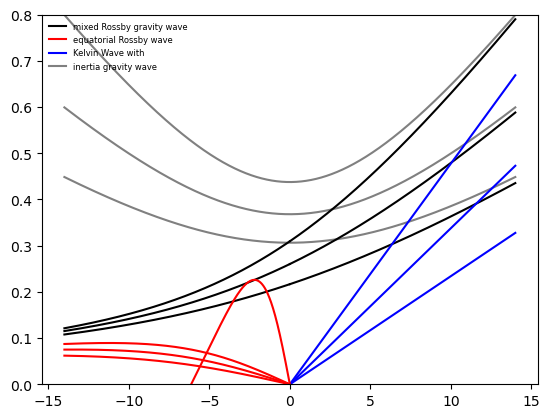

In [5]:
plt.figure()
making_theoretical_line()


### calculation

In [6]:
# prec_daily             = average_every_n_steps(var["prec"][:,:,:],4)   # making daily data
# prec_daily_chunk       = split_with_overlap(prec_daily,50)             # 50-day window as the chunk size
# print("dimension of prec_daily_chunk is"+str(prec_daily_chunk.shape))
# dim_chunk, dim_time, dim_lat, dim_lon      = prec_daily_chunk.shape

# # testing 
# A_kw, B_kw, a_kw, b_kw = FFT2D(prec_daily_chunk[0,:,0,:],dim_time,dim_lon)
# ##################################################################################
# u_daily             = average_every_n_steps(var["u"][:,:,:],4)   # making daily data
# u_daily_chunk       = split_with_overlap(u_daily,50)             # 50-day window as the chunk size
# print("dimension of prec_daily_chunk is"+str(u_daily_chunk.shape))
# dim_chunk, dim_time, dim_lat, dim_lon      = u_daily_chunk.shape

# # testing 
# A_kw, B_kw, a_kw, b_kw = FFT2D(u_daily_chunk[0,:,0,:],dim_time,dim_lon)
# ##################################################################################
# v_daily             = average_every_n_steps(var["v"][:,:,:],4)   # making daily data
# v_daily_chunk       = split_with_overlap(v_daily,50)             # 50-day window as the chunk size
# print("dimension of prec_daily_chunk is"+str(v_daily_chunk.shape))
# dim_chunk, dim_time, dim_lat, dim_lon      = v_daily_chunk.shape

# # testing 
# A_kw, B_kw, a_kw, b_kw = FFT2D(v_daily_chunk[0,:,0,:],dim_time,dim_lon)

In [7]:
prec_daily_0             = average_every_n_steps(var_0["prec"][:,:,:],4)   # making daily data
##################################################################################
u_daily_0             = average_every_n_steps(var_0["u"][:,:,:],4)   # making daily data
##################################################################################
v_daily_0             = average_every_n_steps(var_0["v"][:,:,:],4)   # making daily data

In [8]:
prec_daily_50             = average_every_n_steps(var_50["prec"][:,:,:],4)   # making daily data
##################################################################################
u_daily_50             = average_every_n_steps(var_50["u"][:,:,:],4)   # making daily data
##################################################################################
v_daily_50             = average_every_n_steps(var_50["v"][:,:,:],4)   # making daily data

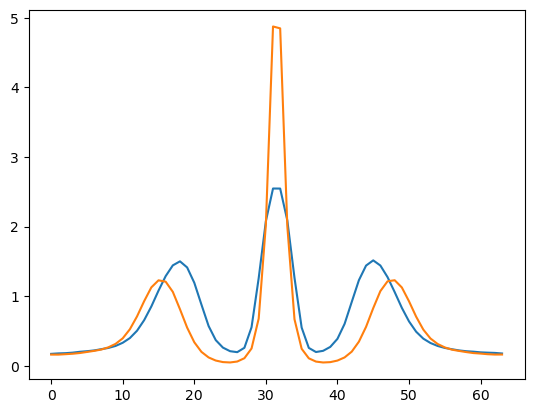

In [9]:
# prec_daily.shape
plt.figure()
plt.plot(prec_daily_0.mean(axis=(0,2)))
plt.plot(prec_daily_50.mean(axis=(0,2)))


(19500,)
(19500,)


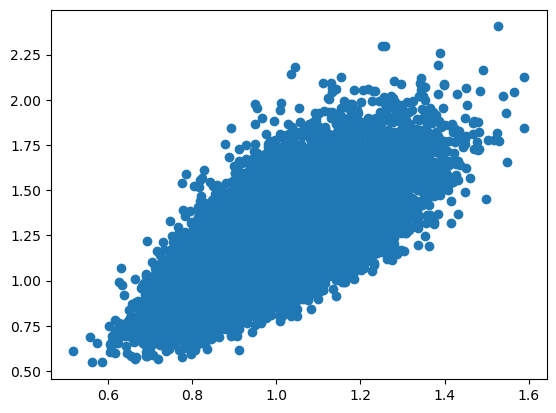

In [10]:
print(np.var(prec_daily_50[:,32-8:32+8].mean(axis=(1)), axis=1).shape)
plt.figure()
plt.scatter(prec_daily_50[:,32-8:32+8].mean(axis=(1,2)), np.sqrt(np.var(prec_daily_50[:,32-8:32+8].mean(axis=(1)), axis=1)))
print(prec_daily_50[:,32-8:32+8].mean(axis=(1,2)).shape)

## Reconstruct the time series 

In [11]:
# # Synethic Data 
# x     = np.linspace(0,128,128)
# t     = np.linspace(0,50,50)
# xx,tt = np.meshgrid(x,t)


# plt.figure()
# cs=plt.contourf(np.cos(2*np.pi/128*(xx-tt/50*128)))
# plt.colorbar(cs)
# tmp     = np.cos(2*np.pi/128*(xx-tt/50*128))

# A_kw, B_kw, a_kw, b_kw = FFT2D(tmp,dim_time,dim_lon)
# P_T                    = np.zeros([2,A_kw.shape[0],A_kw.shape[1]]) # eastward/westward, wave number, frequency

# count   = 0

# ## West component, B_kw, a_kw
# ## East component, A_kw, b_kw

# #for i in range(dim_chunk):
# for i in range(1):
#     A_kw, B_kw, a_kw, b_kw   = FFT2D(tmp,dim_time,dim_lon)
#     P_T[0,:,:]               = ((1/8*(A_kw**2+B_kw**2)+1/8*(a_kw**2+b_kw**2)+1/4*(a_kw*B_kw-A_kw*b_kw))+P_T[0,:,:]*count)/(count+1)
#     P_T[1,:,:]               = ((1/8*(A_kw**2+B_kw**2)+1/8*(a_kw**2+b_kw**2)-1/4*(a_kw*B_kw-A_kw*b_kw))+P_T[1,:,:]*count)/(count+1)
# P_total = np.zeros((w_max,2*k_max+1))
# P_total[:,k_max]         = (P_T[0,0:w_max,0]+P_T[1,0:w_max,0])
# P_total[:,k_max+1:]      = P_T[0,0:w_max,1:k_max+1] 
# P_total[:,k_max-1::-1]   = P_T[1,0:w_max,1:k_max+1] 
# plt.figure()
# cs=plt.contourf(-k,w/50,P_total[:,:],extend='both',cmap='gray_r')
# plt.colorbar(cs)
# plt.xlim([-3,3])

In [12]:
# # Prec
# tmp_s  = prec_daily_chunk[0,:,lat_cond.min():32,:][:,::-1,:]
# tmp_n  = prec_daily_chunk[0,:,32:lat_cond.max()+1,:]
# # OLNY for U and P !!!
# # find symmetric u(time, y, x) -> then fft -> do u' (time, y, x)
# # 1. tmp_mean = (tmp_n - tmp_s) /2 # (time, 1, x) 
# # 2. tmp_filter = space_time_recon(tmp_mean,wnm_ref=1,frm_ref=1,direction='east')
# # 3. 
# # tmp_filter_s = tmp_filter/2
# # tmp_filter_n = tmp_filter/2

# tmp_mean = (tmp_s + tmp_n) /2 

# tmp_filter = space_time_recon(tmp_mean, wnm_ref=1, frm_ref=1, direction='east')
# tmp_filter_s = tmp_filter/2
# tmp_filter_n = tmp_filter/2 # == u'(time, (32-27), x)
# """
# # 11/23 
# # TODO: 1. first test wnm_ref=2,frm_ref=2 -> quiver(u', v')
# # TODO: 2. for loop all over y -> u' (time, y, x)!!!
# """
# ##################################################################################
# # u
# # OLNY for U and P !!!
# # find symmetric u(time, y, x) -> then fft -> do u' (time, y, x)
# # 1. tmp_mean = (tmp_n - tmp_s) /2 # (time, 1, x) 
# # 2. tmp_filter = space_time_recon(tmp_mean,wnm_ref=1,frm_ref=1,direction='east')
# # 3. 
# # tmp_filter_s = tmp_filter/2
# # tmp_filter_n = tmp_filter/2

# u_tmp_s  = u_daily_chunk[0,:,lat_cond.min():32,:][:,::-1,:]
# u_tmp_n  = u_daily_chunk[0,:,32:lat_cond.max()+1,:]
# print(u_tmp_s.shape, u_tmp_n.shape)


# u_tmp_mean = (u_tmp_s + u_tmp_n) /2 

# u_tmp_filter = space_time_recon(u_tmp_mean, wnm_ref=1, frm_ref=1, direction='east')
# u_tmp_filter_s = u_tmp_filter/2
# u_tmp_filter_n = u_tmp_filter/2 # == u'(time, (32-27), x)
# """
# # 11/23 
# # TODO: 1. first test wnm_ref=2,frm_ref=2 -> quiver(u', v')
# # TODO: 2. for loop all over y -> u' (time, y, x)!!!
# """
# ##################################################################################
# ##################################################################################
# # v
# # OLNY for V and vor !!!
# # find symmetric v(time, y, x) -> then fft -> do v' (time, y, x)
# # 1. tmp_mean = (tmp_n - tmp_s) /2 # (time, 1, x) 
# # 2. tmp_filter = space_time_recon(tmp_mean,wnm_ref=1,frm_ref=1,direction='east')
# # 3. 
# # tmp_filter_s = -tmp_filter/2
# # tmp_filter_n = tmp_filter/2
# v_tmp_s  = v_daily_chunk[0,:,lat_cond.min():32,:][:,::-1,:]
# v_tmp_n  = v_daily_chunk[0,:,32:lat_cond.max()+1,:]

# v_tmp_mean = (v_tmp_s + v_tmp_n) /2 

# v_tmp_filter = space_time_recon(v_tmp_mean, wnm_ref=1, frm_ref=1, direction='east')
# v_tmp_filter_s = -v_tmp_filter/2
# v_tmp_filter_n = v_tmp_filter/2 # == v'(time, (32-27), x)


# EMF_s = u_tmp_filter_s * v_tmp_filter_s
# EMF_n = u_tmp_filter_n * v_tmp_filter_n
# # print(EMF_s.shape)
# EMF_global          = np.append(EMF_s[:,::-1], EMF_n, axis=1)
# u_tmp_filter_global = np.append(u_tmp_filter_s[:,::-1], u_tmp_filter_n, axis=1)
# v_tmp_filter_global = np.append(v_tmp_filter_s[:,::-1], v_tmp_filter_n, axis=1)

# x = np.linspace(0,360,128)
# y = np.linspace(-15,15,10)
# xx, yy = np.meshgrid(x,y)
# plt.figure()
# idx = 1
# idy = 4

# cs=plt.contourf(xx, yy, EMF_global[0], levels=11)
# # plt.quiver(xx[::idx, ::idy], yy[::idx, ::idy], u_normalized, v_normalized, 
# #            color="black", scale_units='xy', angles='xy', width=4e-3, scale=250E-3)
# plt.quiver(xx[::idx, ::idy], yy[::idx, ::idy], u_tmp_filter_global[0][::idx, ::idy], v_tmp_filter_global[0][::idx, ::idy]
#            ,color="black", scale_units='xy', angles='xy', width=4e-3, scale=32E-3)
# # cs=plt.contour(np.squeeze(tmp_filter))
# plt.colorbar(cs)
# plt.title("wnm_ref=4, frm_ref=4, Shading: EMF, vertor= (u',v')")


# plt.figure()
# plt.title("u[0,5,:], wnm_ref=4, frm_ref=4")
# plt.plot(x, u_tmp_filter_global[0,5,:])

## Take PC1 time index > and < std  

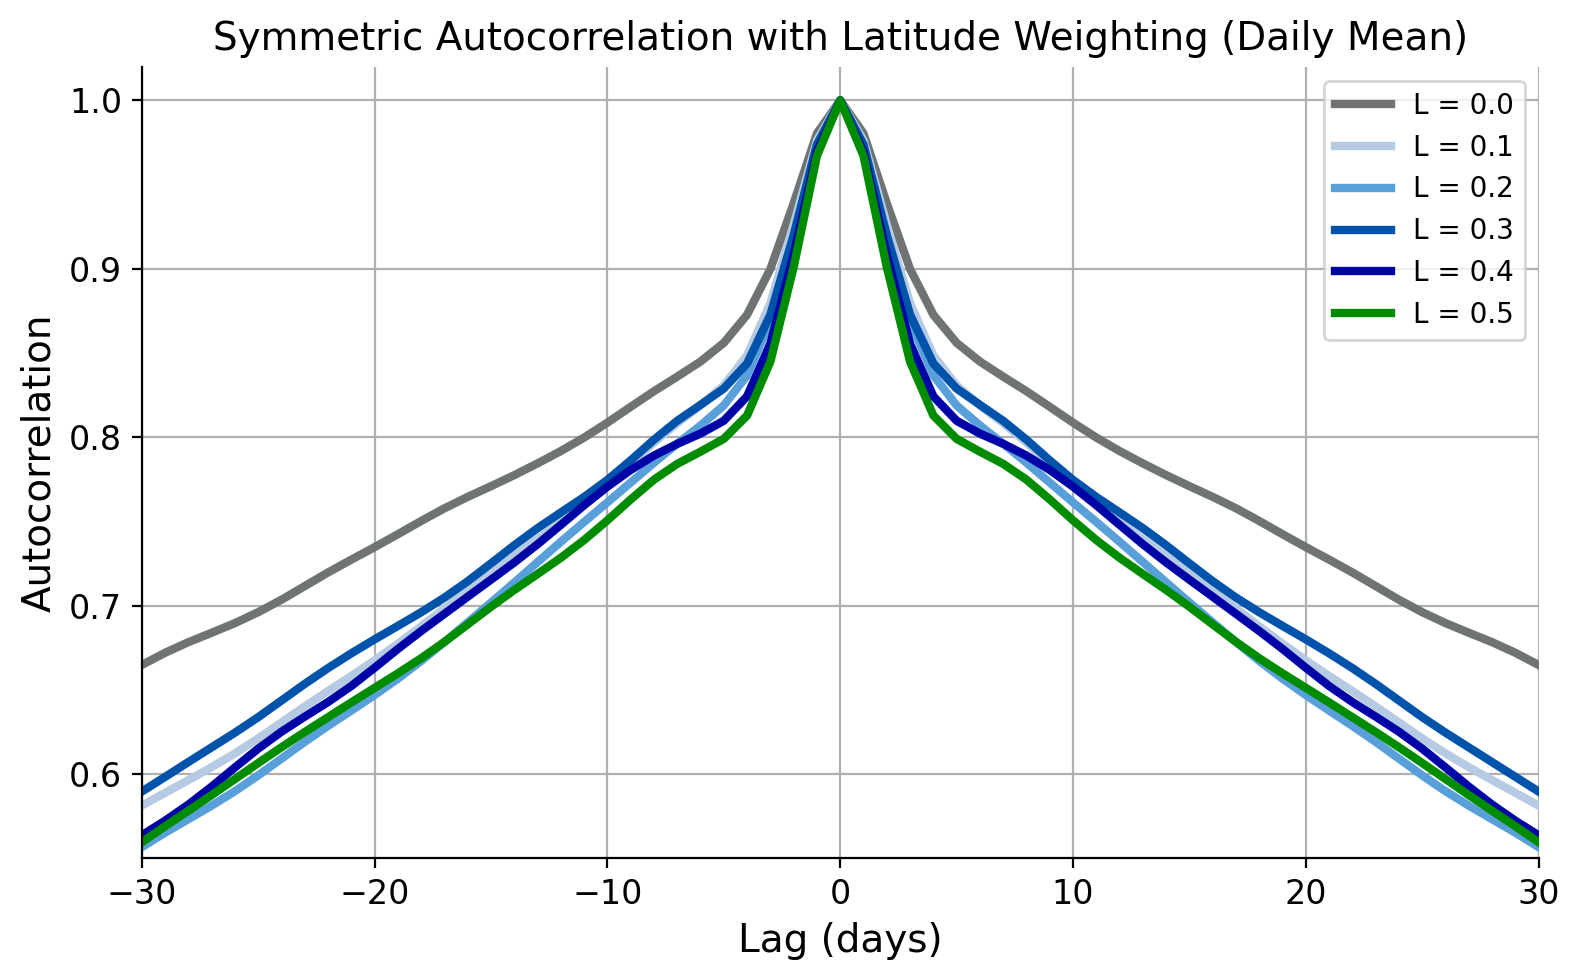

In [13]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

sys.path.append("back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/")
from EOF import EOF


class Moist_Dycore_Package:
    def __init__(self, zonal_dimension: int = 3):
        self.zonal_dimension = zonal_dimension

    def zonal_mean(self, data):
        return np.mean(data, axis=self.zonal_dimension, keepdims=True)

    def zonal_anomaly(self, data):
        mean = self.zonal_mean(data)
        np.subtract(data, mean, out=data)
        return data

    def load_data(self, file_path, variable_name):
        with h5py.File(file_path, "r") as file:
            return np.array(file[variable_name], dtype=np.float32)

    def calculate_daily_mean(self, data):
        """
        Calculate daily mean data from 6-hourly data.
        Assumes the time dimension is the first axis.
        """
        num_days = data.shape[0] // 4  # Calculate number of days
        daily_mean = data[:num_days * 4].reshape(num_days, 4, -1).mean(axis=1)
        return daily_mean

    def calculate_EOF_with_custom_class(self, input_data, latitudes, n_components: int = 32, field: str = "2D"):
        weights = np.sqrt(np.cos(np.radians(latitudes)))
        weighted_data = input_data * weights

        eof_instance = EOF((weighted_data,), n_components=n_components, field=field)
        eof_instance.get()

        EOF_modes = eof_instance.EOF[0]
        PCs = eof_instance.PC[0]
        explained_variance = eof_instance.explained

        #EOFs_normalized = EOF_modes / PCs.std(axis=0)
        PCs_normalized  = PCs / PCs.std(axis=0)
        
        

        return EOF_modes, PCs_normalized, explained_variance

    def symmetric_autocorr(self, x, max_lag, split_to_chunk, window_length, overlap=250):
        if not split_to_chunk:
            corr = np.zeros(2 * max_lag + 1)
            for l in range(-max_lag, max_lag + 1):
                if l == 0:
                    corr[l + max_lag] = 1.0
                elif l > 0:
                    corr[l + max_lag] = np.corrcoef(x[l:], x[:-l])[0][1]
                else:
                    corr[l + max_lag] = np.corrcoef(x[:l], x[-l:])[0][1]
            return corr
        else:
            step_size = window_length - overlap
            num_windows = (len(x) - overlap) // step_size
            corr = np.zeros((num_windows, 2 * max_lag + 1))

            for i in range(num_windows):
                start = i * step_size
                end = start + window_length
                x_window = x[start:end]

                if len(x_window) < window_length:
                    break

                for l in range(-max_lag, max_lag + 1):
                    if l == 0:
                        corr[i, l + max_lag] = 1.0
                    elif l > 0:
                        corr[i, l + max_lag] = np.corrcoef(x_window[l:], x_window[:-l])[0, 1]
                    else:
                        corr[i, l + max_lag] = np.corrcoef(x_window[:l], x_window[-l:])[0, 1]

            return corr.mean(axis=0)


# Initialize the Package
moist_dycore = Moist_Dycore_Package(zonal_dimension=3)

# Parameters
PR_values = [0, 10, 20, 30, 40, 50]
colors = np.array([[112, 115, 115], [182, 203, 227], [89, 159, 218],
                   [0, 83, 170], [0, 4, 167], [0, 140, 1]]) / 255.0
auto_length = 100
window_length = 500
split_to_chunk = False
latitudes = np.linspace(0, 90, 32)

# Load data, calculate daily mean, and compute PC1 for all PR values
PC1_all  = []
EOFs_all = []


for PR in PR_values:
    file_path = f"/data92/PeterChang/1120_preprocessing/PR{PR}/climatology/u_add_time_dim/u_climatology_add_time_dim.h5"
    variable_name = "u"
    u_data = moist_dycore.load_data(file_path, variable_name)
    
    # Calculate daily mean
    u_daily = moist_dycore.calculate_daily_mean(u_data)

    # Use the custom EOF class
    EOFs, PC_normalized, _ = moist_dycore.calculate_EOF_with_custom_class(u_daily[:, 32:], latitudes, n_components=32, field="1D")
    EOFs_all.append(EOFs[:])  # Extract normalized PC1 for the current PR value
    PC1_all.append(PC_normalized[:])  # Extract normalized PC1 for the current PR value
    

PC1_all  = np.array(PC1_all)
EOFs_all = np.array(EOFs_all)


# Calculate symmetric autocorrelation for PC1
autocorr_results = []
for i in range(len(PR_values)):
    autocorr_results.append(
        moist_dycore.symmetric_autocorr(PC1_all[i, :], auto_length, split_to_chunk, window_length)
    )

# tau for plotting
tau_full = np.arange(-auto_length, auto_length + 1)

# Plot the symmetric autocorrelation
fig, ax = plt.subplots(1, figsize=(8, 5), dpi=200)
mpl.rcParams['axes.linewidth'] = 1.5

for i, PR in enumerate(PR_values):
    ax.plot(tau_full, autocorr_results[i], label=f"L = {PR * 0.01}", color=colors[i], lw=3)

# Customize plot
ax.set_title("Symmetric Autocorrelation with Latitude Weighting (Daily Mean)", fontsize=14)
ax.set_xlabel("Lag (days)", fontsize=14)
ax.set_ylabel("Autocorrelation", fontsize=14)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xlim([-30, 30])
plt.ylim([0.55, 1.02])
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


1.0000000000000002


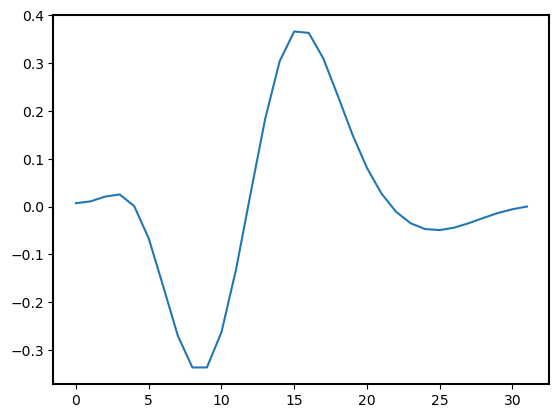

In [15]:
EOF1_all = EOFs_all
plt.figure()
plt.plot(EOF1_all[0])
print(EOF1_all[1].dot(EOF1_all[1]))

In [16]:
EOF1_all = EOFs_all
print(EOF1_all.shape)

(6, 32)


In [ ]:
import numpy as np
import h5py
import time

# Define your inputs
lat = np.linspace(-90, 90, 64)
lat_cond = np.where((lat >= -30) & (lat <= 30))[0]


# Differentiation matrix
yd_tropic = lat[lat_cond]
lat_size = yd_tropic.shape[0]
radius = 6.37122e6
cy_tropic = np.cos(np.deg2rad(yd_tropic))
cy2_tropic = cy_tropic ** 2
delta_y = np.diff(np.deg2rad(yd_tropic))

D = np.zeros((lat_size, lat_size))
for i in range(1, lat_size - 1):
    D[i, i - 1] = -cy2_tropic[i] / (cy2_tropic[i] * (delta_y[i - 1] + delta_y[i]))
    D[i, i + 1] = cy2_tropic[i] / (cy2_tropic[i] * (delta_y[i - 1] + delta_y[i]))
D[0, 0] = -1 / delta_y[0]
D[0, 1] = 1 / delta_y[0]
D[-1, -2] = -1 / delta_y[-1]
D[-1, -1] = 1 / delta_y[-1]
D = D / radius

# Initialize the contribution storage
contribution_results = {}
EMF_results = {}
y = lat

for PR in [0,50]:
    if PR ==0:
        exp_sel = 0
    elif PR ==50:
        exp_sel = -1
    # read data
    level_index      = 5
    file_path        = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
    
    
    # define variables
    lat              = np.linspace(-90, 90, 64)
    lat_cond         = np.where((lat>=-30)&(lat<=30))[0]
    var              = {}
    var_list         = {'p','prec','u','v'}
    for index, var_i in enumerate(var_list):
        with h5py.File(f"{file_path}/PR{PR}/{var_i}/PR{PR}_500_20000day_6hourly_{var_i}.dat") as f:
            if var_i == 'prec':
                var[f"{var_i}"] = f[var_i][:, :,:]*86400
            else:
                var[f"{var_i}"] = f[var_i][:, level_index, :]


    prec_daily             = average_every_n_steps(var["prec"][:,:,:],4)   # making daily data
    prec_daily_chunk       = split_with_overlap(prec_daily,50)             # 50-day window as the chunk size
    print("dimension of prec_daily_chunk is"+str(prec_daily_chunk.shape))
    dim_chunk, dim_time, dim_lat, dim_lon      = prec_daily_chunk.shape
    
    # testing 
    A_kw, B_kw, a_kw, b_kw = FFT2D(prec_daily_chunk[0,:,0,:],dim_time,dim_lon)
    ##################################################################################
    u_daily             = average_every_n_steps(var["u"][:,:,:],4)   # making daily data
    u_daily_chunk       = split_with_overlap(u_daily,50)             # 50-day window as the chunk size
    print("dimension of prec_daily_chunk is"+str(u_daily_chunk.shape))
    dim_chunk, dim_time, dim_lat, dim_lon      = u_daily_chunk.shape
    
    # testing 
    A_kw, B_kw, a_kw, b_kw = FFT2D(u_daily_chunk[0,:,0,:],dim_time,dim_lon)
    ##################################################################################
    v_daily             = average_every_n_steps(var["v"][:,:,:],4)   # making daily data
    v_daily_chunk       = split_with_overlap(v_daily,50)             # 50-day window as the chunk size
    print("dimension of prec_daily_chunk is"+str(v_daily_chunk.shape))
    dim_chunk, dim_time, dim_lat, dim_lon      = v_daily_chunk.shape
    
    # testing 
    A_kw, B_kw, a_kw, b_kw = FFT2D(v_daily_chunk[0,:,0,:],dim_time,dim_lon)


    # Loop over wave numbers, frequencies, and directions
    for wnm_sel in range(0, 10):  # Wave numbers 1 to 5
        for frm_sel in range(0, 26):  # Frequencies 1 to 10
            for direction in ['east', 'west']:  # Both directions
                print(f"Processing PR: {PR}, wnm: {wnm_sel}, frm: {frm_sel}, direction: {direction}")
    
                # Filtered results for u and v
                y_tropic = 32 - lat_cond.min()
    
                # Initialize arrays for the current combination of wnm, frm, direction
                # Ensures no residual data from previous iterations
                EMF_global = np.zeros((19500, y[lat_cond].size, 128))
                u_tmp_filter_global = np.zeros((19500, y[lat_cond].size, 128))
                v_tmp_filter_global = np.zeros((19500, y[lat_cond].size, 128))
    
                # Apply spatial-temporal filtering for each day
                for i in range(25, u_daily.shape[0] - 25):
                    u_daily_window = u_daily[(i - 25):(i + 25), :, :]
                    v_daily_window = v_daily[(i - 25):(i + 25), :, :]
    
                    # Split northern and southern regions
                    tmp_s_u = u_daily_window[:, lat_cond.min():32, :][:, ::-1, :]
                    tmp_n_u = u_daily_window[:, 32:lat_cond.max() + 1, :]
                    tmp_s_v = v_daily_window[:, lat_cond.min():32, :][:, ::-1, :]
                    tmp_n_v = v_daily_window[:, 32:lat_cond.max() + 1, :]
    
                    # Compute symmetric mean
                    tmp_mean_u = (tmp_s_u + tmp_n_u) / 2
                    tmp_mean_v = (tmp_n_v - tmp_s_v) / 2 # 12/25 fixed north - south!!! npt north + south
    
                    # Apply spatial-temporal filtering
                    tmp_filter_u = space_time_recon(tmp_mean_u, wnm_ref=wnm_sel, frm_ref=frm_sel, direction=direction)
                    tmp_filter_v = space_time_recon(tmp_mean_v, wnm_ref=wnm_sel, frm_ref=frm_sel, direction=direction)
    
                    # Assign filtered results
                    u_tmp_s = tmp_filter_u[25, :, :] / 2  # Southern region
                    u_tmp_n = tmp_filter_u[25, :, :] / 2  # Northern region
                    v_tmp_s = -tmp_filter_v[25, :, :] / 2  # Southern region
                    v_tmp_n = tmp_filter_v[25, :, :] / 2  # Northern region
    
                    EMF_s = u_tmp_s * v_tmp_s  # Southern region EMF
                    EMF_n = u_tmp_n * v_tmp_n  # Northern region EMF
    
                    # Use np.concatenate instead of np.append to avoid unintended results
                    EMF_global[i, :, :] = np.concatenate((EMF_s[::-1, :], EMF_n), axis=0)
                    u_tmp_filter_global[i, :, :] = np.concatenate((u_tmp_s[::-1], u_tmp_n), axis=0)
                    v_tmp_filter_global[i, :, :] = np.concatenate((v_tmp_s[::-1], v_tmp_n), axis=0)
    
                # Compute dM/dy
                Mzm = np.mean(EMF_global, axis=2)  # Mean over longitude
                dmdy = -Mzm @ D.T  # Use the differentiation matrix
    
                # Calculate contributions
                EOF1_dry = EOF1_all[exp_sel, 0:int(lat_size / 2)]  # Select EOF1 for the dry experiment
                contribution = np.dot(dmdy[:, int(lat_size / 2):], EOF1_dry)
    
                # Save results for the current wave number, frequency, and direction
                contribution_results[(wnm_sel, frm_sel, direction)] = contribution
                EMF_results[(wnm_sel, frm_sel, direction)] = EMF_global
    
    # Save results as a dictionary
    print("Saving results...")
    
    # Save contribution results
    output_file_contributions = f"/data92/PeterChang/1120_preprocessing/PR{PR}/dmdy_contribution_AM/PR{PR}_contribution_results_all.h5"
    with h5py.File(output_file_contributions, "w") as h5f:
        for key, contributions in contribution_results.items():
            group_name = f"wnm_{key[0]}_frm_{key[1]}_dir_{key[2]}"
            h5f.create_dataset(f"{group_name}/contributions", data=contributions)
    
    print(f"Saved contributions to {output_file_contributions}")
    
    # Save EMF results
    output_file_emf = f"/data92/PeterChang/1120_preprocessing/PR{PR}/dmdy_contribution_AM/PR{PR}_EMF_filter_results_all.h5"
    with h5py.File(output_file_emf, "w") as h5f:
        for key, emf_global in EMF_results.items():
            group_name = f"wnm_{key[0]}_frm_{key[1]}_dir_{key[2]}"
            h5f.create_dataset(f"{group_name}/EMF_global", data=emf_global)
    
    print(f"Saved EMF results to {output_file_emf}")

print("Calculate all wn and frq done!!!")

In [ ]:
print("Merry Chrismas!!!")

# Calculate all 

In [17]:
lat_cond         = np.where((lat>=-15)&(lat<=15))[0]

prec_daily_time_0  = np.mean(prec_daily_0[:,lat_cond,:], axis=(1,2))
prec_daily_time_50 = np.mean(prec_daily_50[:,lat_cond,:], axis=(1,2))


idx_0          = np.where(prec_daily_time_0 > prec_daily_time_0.mean() + prec_daily_time_0.std())[0]
idx_0_negative = np.where(prec_daily_time_0 < prec_daily_time_0.mean() - prec_daily_time_0.std())[0]

idx_50          = np.where(prec_daily_time_50 > prec_daily_time_50.mean() + prec_daily_time_50.std())[0]
idx_50_negative = np.where(prec_daily_time_50 < prec_daily_time_50.mean() - prec_daily_time_50.std())[0]


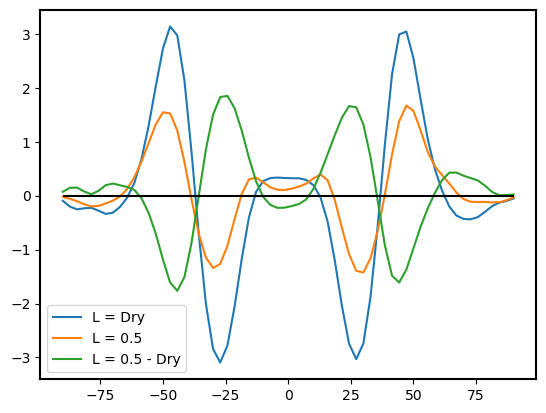

In [18]:
idx_0_lag = idx_0+10
idx_0_lag = idx_0_lag[idx_0_lag<19500]

idx_50_lag = idx_50+10
idx_50_lag = idx_50_lag[idx_50_lag<19500]

u_0_final = u_daily_0[idx_0_lag].mean(axis=(0,2))   - u_daily_0[:].mean(axis=(0,2))
u_50_final  = u_daily_50[idx_50_lag].mean(axis=(0,2)) - u_daily_50[:].mean(axis=(0,2))

y = np.linspace(-90,90,64)
plt.figure()
plt.plot(y,u_0_final, label="L = Dry")
plt.plot(y,u_50_final, label="L = 0.5")

plt.plot(y, u_50_final - u_0_final  , label="L = 0.5 - Dry")



plt.legend()

plt.hlines(y= 0, xmin=-90, xmax=90, color="Black")

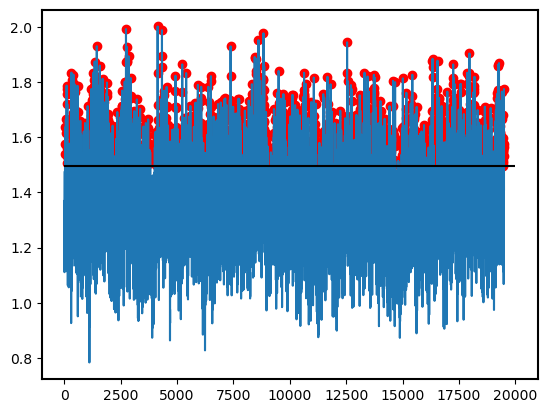

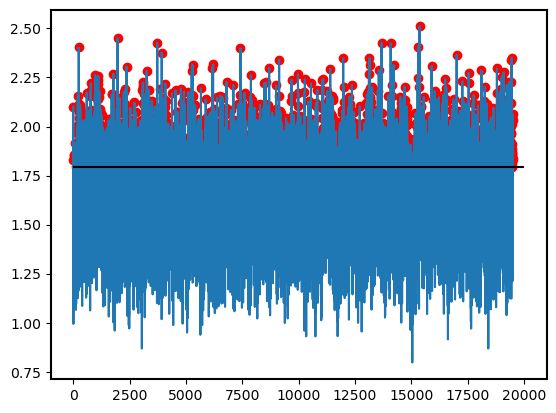

In [19]:
plt.figure()
plt.plot(prec_daily_time_0)
plt.scatter(idx_0, prec_daily_time_0[idx_0], color="Red")
plt.hlines(y=prec_daily_time_0.mean() + prec_daily_time_0.std(), xmin=0, xmax=20000, color="Black")

plt.figure()
plt.plot(prec_daily_time_50)
plt.scatter(idx_50, prec_daily_time_50[idx_50], color="Red")
plt.hlines(y=prec_daily_time_50.mean() + prec_daily_time_50.std(), xmin=0, xmax=20000, color="Black")

In [20]:
import h5py
# PR = 0
PR = 0 
output_file = f"/data92/PeterChang/1120_preprocessing/PR{PR}/dmdy_contribution_AM/PR{PR}_contribution_results_all.h5"
m_final_0      = np.zeros((10, 25, 19500))
m_final_west_0 = np.zeros((10, 25, 19500))

dataset_key = 'contributions'  # Adjust based on your file structure

for i in range(m_final_0.shape[0]):
    for j in range(m_final_0.shape[1]):
        with h5py.File(output_file, "r") as f:
            group_key      = f'wnm_{int(i)}_frm_{int(j)}_dir_east'
            m_final_0[i,j,:] = f[f"{group_key}/{dataset_key}"][:]  # Access the dataset
            group_key      = f'wnm_{int(i)}_frm_{int(j)}_dir_west'
            m_final_west_0[i,j,:] = f[f"{group_key}/{dataset_key}"][:]  # Access the dataset
############################################################################################################################
PR = 50
output_file = f"/data92/PeterChang/1120_preprocessing/PR{PR}/dmdy_contribution_AM/PR{PR}_contribution_results_all.h5"
m_final_50      = np.zeros((10, 25, 19500))
m_final_west_50 = np.zeros((10, 25, 19500))

dataset_key = 'contributions'  # Adjust based on your file structure

for i in range(m_final_50.shape[0]):
    for j in range(m_final_50.shape[1]):
        with h5py.File(output_file, "r") as f:
            group_key      = f'wnm_{int(i)}_frm_{int(j)}_dir_east'
            m_final_50[i,j,:] = f[f"{group_key}/{dataset_key}"][:]  # Access the dataset
            group_key      = f'wnm_{int(i)}_frm_{int(j)}_dir_west'
            m_final_west_50[i,j,:] = f[f"{group_key}/{dataset_key}"][:]  # Access the dataset
print(m_final_west_50.shape)


(10, 25, 19500)


62 71
0 24
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053
62 71
0 24
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


Text(0.5, 1.0, 'PR=50 - clim, lag = 0 prec_idx > 1 * std')

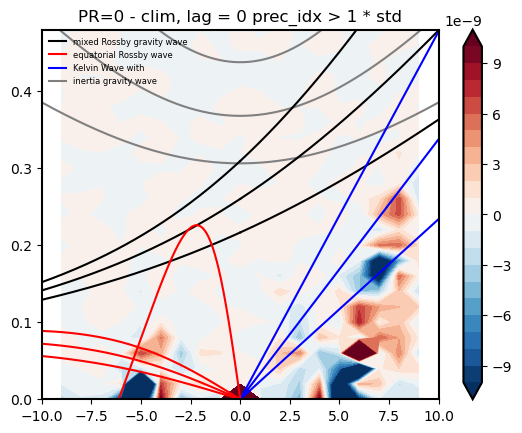

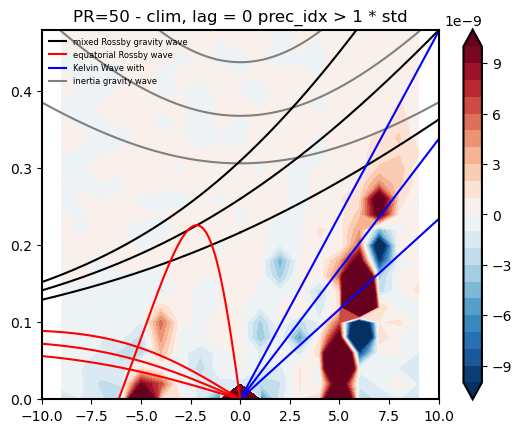

In [21]:
PR = 0
k_max       = 62
w_max       = 25

wave_number = np.arange(-k_max,k_max+1,1) # 125
frequency   = np.arange(0,w_max,1)        # 24
k,w         = np.meshgrid(wave_number,frequency) # (24,125)

index_of_wave_number_big = int(np.where(wave_number == 9)[0][0])
index_of_wave_number_sml = int(np.where(wave_number == 0)[0][0])

index_of_frequency_big   = int(np.where(frequency == 24)[0][0]) # maximum is 23
index_of_frequency_sml   = int(np.where(frequency == 0)[0][0])

print(index_of_wave_number_sml, index_of_wave_number_big)
print(index_of_frequency_sml, index_of_frequency_big)



# m_final_positive_idx = m_final[m_final > m_final.std()][0]
m_final_clim_idx_0          = m_final_0[:,:,:].mean(axis=2)
m_final_positive_idx_0      = m_final_0[:,:,idx_0].mean(axis=2)

m_final_clim_west_positive_idx_0 = m_final_west_0[:,:,:].mean(axis=2)
m_final_west_positive_idx_0      = m_final_west_0[:,:,idx_0].mean(axis=2)

# print(m_final_west_positive_idx.shape)

# m_final[:,:,
plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf( k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
                   w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
                  # np.rollaxis(m_final_positive_idx, axis=1), levels = np.linspace(-0.8E-8,2E-8,11),extend='both',cmap='gray_r')
                   m_final_positive_idx_0 - m_final_clim_idx_0, levels = np.linspace(-1E-8,1E-8,21),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_0 - m_final_clim_west_positive_idx_0, levels = np.linspace(-1E-8,1E-8,21),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR} - clim, lag = 0 prec_idx > 1 * std")
################################################################################################################
PR = 50
k_max       = 62
w_max       = 25

wave_number = np.arange(-k_max,k_max+1,1) # 125
frequency   = np.arange(0,w_max,1)        # 24
k,w         = np.meshgrid(wave_number,frequency) # (24,125)

index_of_wave_number_big = int(np.where(wave_number == 9)[0][0])
index_of_wave_number_sml = int(np.where(wave_number == 0)[0][0])

index_of_frequency_big   = int(np.where(frequency == 24)[0][0]) # maximum is 23
index_of_frequency_sml   = int(np.where(frequency == 0)[0][0])

print(index_of_wave_number_sml, index_of_wave_number_big)
print(index_of_frequency_sml, index_of_frequency_big)



# m_final_positive_idx = m_final[m_final > m_final.std()][0]
m_final_clim_idx_50          = m_final_50[:,:,:].mean(axis=2)
m_final_positive_idx_50      = m_final_50[:,:,idx_50].mean(axis=2)

m_final_clim_west_positive_idx_50 = m_final_west_50[:,:,:].mean(axis=2)
m_final_west_positive_idx_50      = m_final_west_50[:,:,idx_50].mean(axis=2)

# print(m_final_west_positive_idx.shape)

# m_final[:,:,
plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf( k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
                   w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
                  # np.rollaxis(m_final_positive_idx, axis=1), levels = np.linspace(-0.8E-8,2E-8,11),extend='both',cmap='gray_r')
                   m_final_positive_idx_50 - m_final_clim_idx_50, levels = np.linspace(-1E-8,1E-8,21),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_50 - m_final_clim_west_positive_idx_50, levels = np.linspace(-1E-8,1E-8,21),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR} - clim, lag = 0 prec_idx > 1 * std")


(10, 25)
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053
(10, 25)
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


Text(0.5, 1.0, 'PR=50 - clim, lag = 1 prec_idx > 1 * std')

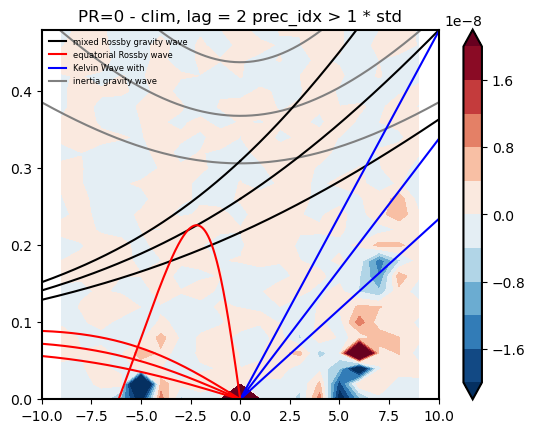

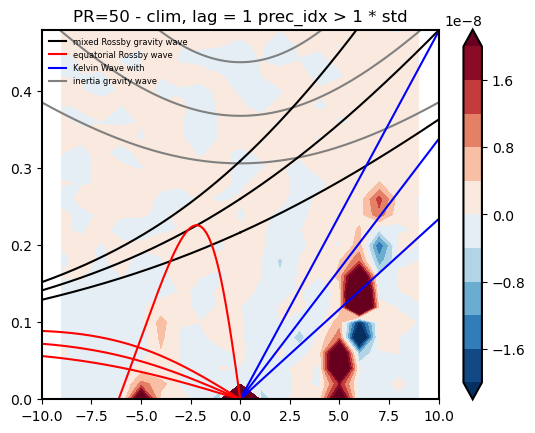

In [22]:
PR = 0
lag = 2
lag_day_0 = idx_0 + lag
lag_day_0 = lag_day_0[lag_day_0 <19500]
# m_final_positive_idx = m_final[m_final > m_final.std()][0]

m_final_positive_idx_0      = m_final_0[:,:,lag_day_0].mean(axis=2)
m_final_west_positive_idx_0 = m_final_west_0[:,:,lag_day_0].mean(axis=2)
print(m_final_west_positive_idx_0.shape)

# m_final[:,:,
plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf( k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
                   w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
                  # np.rollaxis(m_final_positive_idx, axis=1), levels = np.linspace(-0.8E-8,2E-8,11),extend='both',cmap='gray_r')
                   m_final_positive_idx_0 - m_final_clim_idx_0, levels = np.linspace(-2E-8,2E-8,11),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_0 - m_final_clim_west_positive_idx_0, levels = np.linspace(-2E-8,2E-8,11),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR} - clim, lag = {lag} prec_idx > 1 * std")
#######################################################################################################################
PR = 50
lag = 1
lag_day_50 = idx_50 + lag
lag_day_50 = lag_day_50[lag_day_50 <19500]
# m_final_positive_idx = m_final[m_final > m_final.std()][0]

m_final_positive_idx_50      = m_final_50[:,:,lag_day_50].mean(axis=2)
m_final_west_positive_idx_50 = m_final_west_50[:,:,lag_day_50].mean(axis=2)
print(m_final_west_positive_idx_0.shape)

# m_final[:,:,
plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf( k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
                   w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
                  # np.rollaxis(m_final_positive_idx, axis=1), levels = np.linspace(-0.8E-8,2E-8,11),extend='both',cmap='gray_r')
                   m_final_positive_idx_50 - m_final_clim_idx_50, levels = np.linspace(-2E-8,2E-8,11),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_50 - m_final_clim_west_positive_idx_50, levels = np.linspace(-2E-8,2E-8,11),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR} - clim, lag = {lag} prec_idx > 1 * std")


[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


Text(0.5, 1.0, 'PR=50, lag = 2 - clim differen prec_idx > 1*std ')

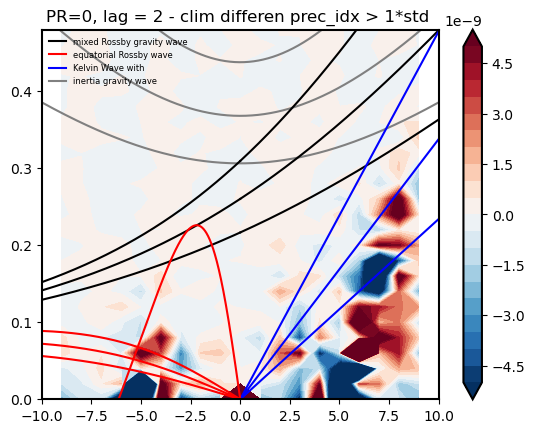

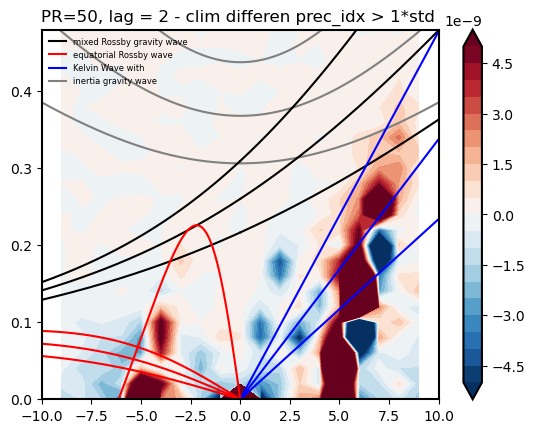

In [23]:
PR = 0
m_final_positive_idx_lag0_0      = m_final_0[:,:,idx_0].mean(axis=2)
m_final_west_positive_idx_lag0_0 = m_final_west_0[:,:,idx_0].mean(axis=2)

lag = 2
lag_day_0 = idx_0+lag
lag_day_0 = lag_day_0[lag_day_0 <19500]

m_final_positive_idx_lag5_0      = m_final_0[:,:,lag_day_0].mean(axis=2)
m_final_west_positive_idx_lag5_0 = m_final_west_0[:,:,lag_day_0].mean(axis=2)

plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf(k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_positive_idx_lag5_0 - m_final_clim_idx_0 , levels = np.linspace(-0.5E-8,0.5E-8,21),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_lag5_0 -  m_final_clim_west_positive_idx_0, levels = np.linspace(-0.5E-8,0.5E-8,21),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR}, lag = {lag} - clim differen prec_idx > 1*std ")
#############################################################################################################
PR = 50
m_final_positive_idx_lag0_50      = m_final_50[:,:,idx_50].mean(axis=2)
m_final_west_positive_idx_lag0_50 = m_final_west_50[:,:,idx_50].mean(axis=2)

lag = 2
lag_day_50 = idx_50+lag
lag_day_50 = lag_day_50[lag_day_50 <19500]

m_final_positive_idx_lag5_50      = m_final_50[:,:,lag_day_50].mean(axis=2)
m_final_west_positive_idx_lag5_50 = m_final_west_50[:,:,lag_day_50].mean(axis=2)

plt.figure()
making_theoretical_line()
# cs=plt.contourf(-k, w/50, P_total,extend='both',cmap='gray_r')
### East
cs = plt.contourf(k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_positive_idx_lag5_50 - m_final_clim_idx_50 , levels = np.linspace(-0.5E-8,0.5E-8,21),extend='both',cmap='RdBu_r')

### West
cs = plt.contourf(-k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/50,
              m_final_west_positive_idx_lag5_50 -  m_final_clim_west_positive_idx_50, levels = np.linspace(-0.5E-8,0.5E-8,21),extend='both',cmap='RdBu_r')

plt.colorbar(cs)
plt.xlim([-10,10])
plt.ylim([0,24/50])
plt.title(f"PR={PR}, lag = {lag} - clim differen prec_idx > 1*std ")

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy import stats

# Statistical test for differences between lag = 2 and lag = 0
PR = 0
alpha = 0.025    # Significance level

# Calculate differences
differences_east_0 = m_final_positive_idx_lag5_0 - m_final_clim_idx_0
differences_west_0 = m_final_west_positive_idx_lag5_0 - m_final_clim_west_positive_idx_0

# Calculate random differences
import random
from scipy.stats import ttest_1samp
##########################################################################################
random_count = 5000
random_differences_east_0 = np.zeros((10,25,random_count))
random_differences_west_0 = np.zeros((10,25,random_count))

for i in range(random_count):
    # randomly select - clim
    random_lag_day_0 = np.asarray(np.random.choice(range(0, 19500), size=idx_0.shape[0], replace=True)) #random_numbers+lag
    random_m_final_positive_idx_lag5_0      = m_final_0[:,:,random_lag_day_0]#.mean(axis=2)
    random_m_final_west_positive_idx_lag5_0 = m_final_west_0[:,:,random_lag_day_0]#.mean(axis=2)    
    
    random_differences_east_0[:,:,i] = (random_m_final_positive_idx_lag5_0.mean(axis=2) - m_final_clim_idx_0[:,:])
    random_differences_west_0[:,:,i] = (random_m_final_west_positive_idx_lag5_0.mean(axis=2) - m_final_clim_west_positive_idx_0[:,:])

print("Randomly select done!")

Randomly select done!


[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


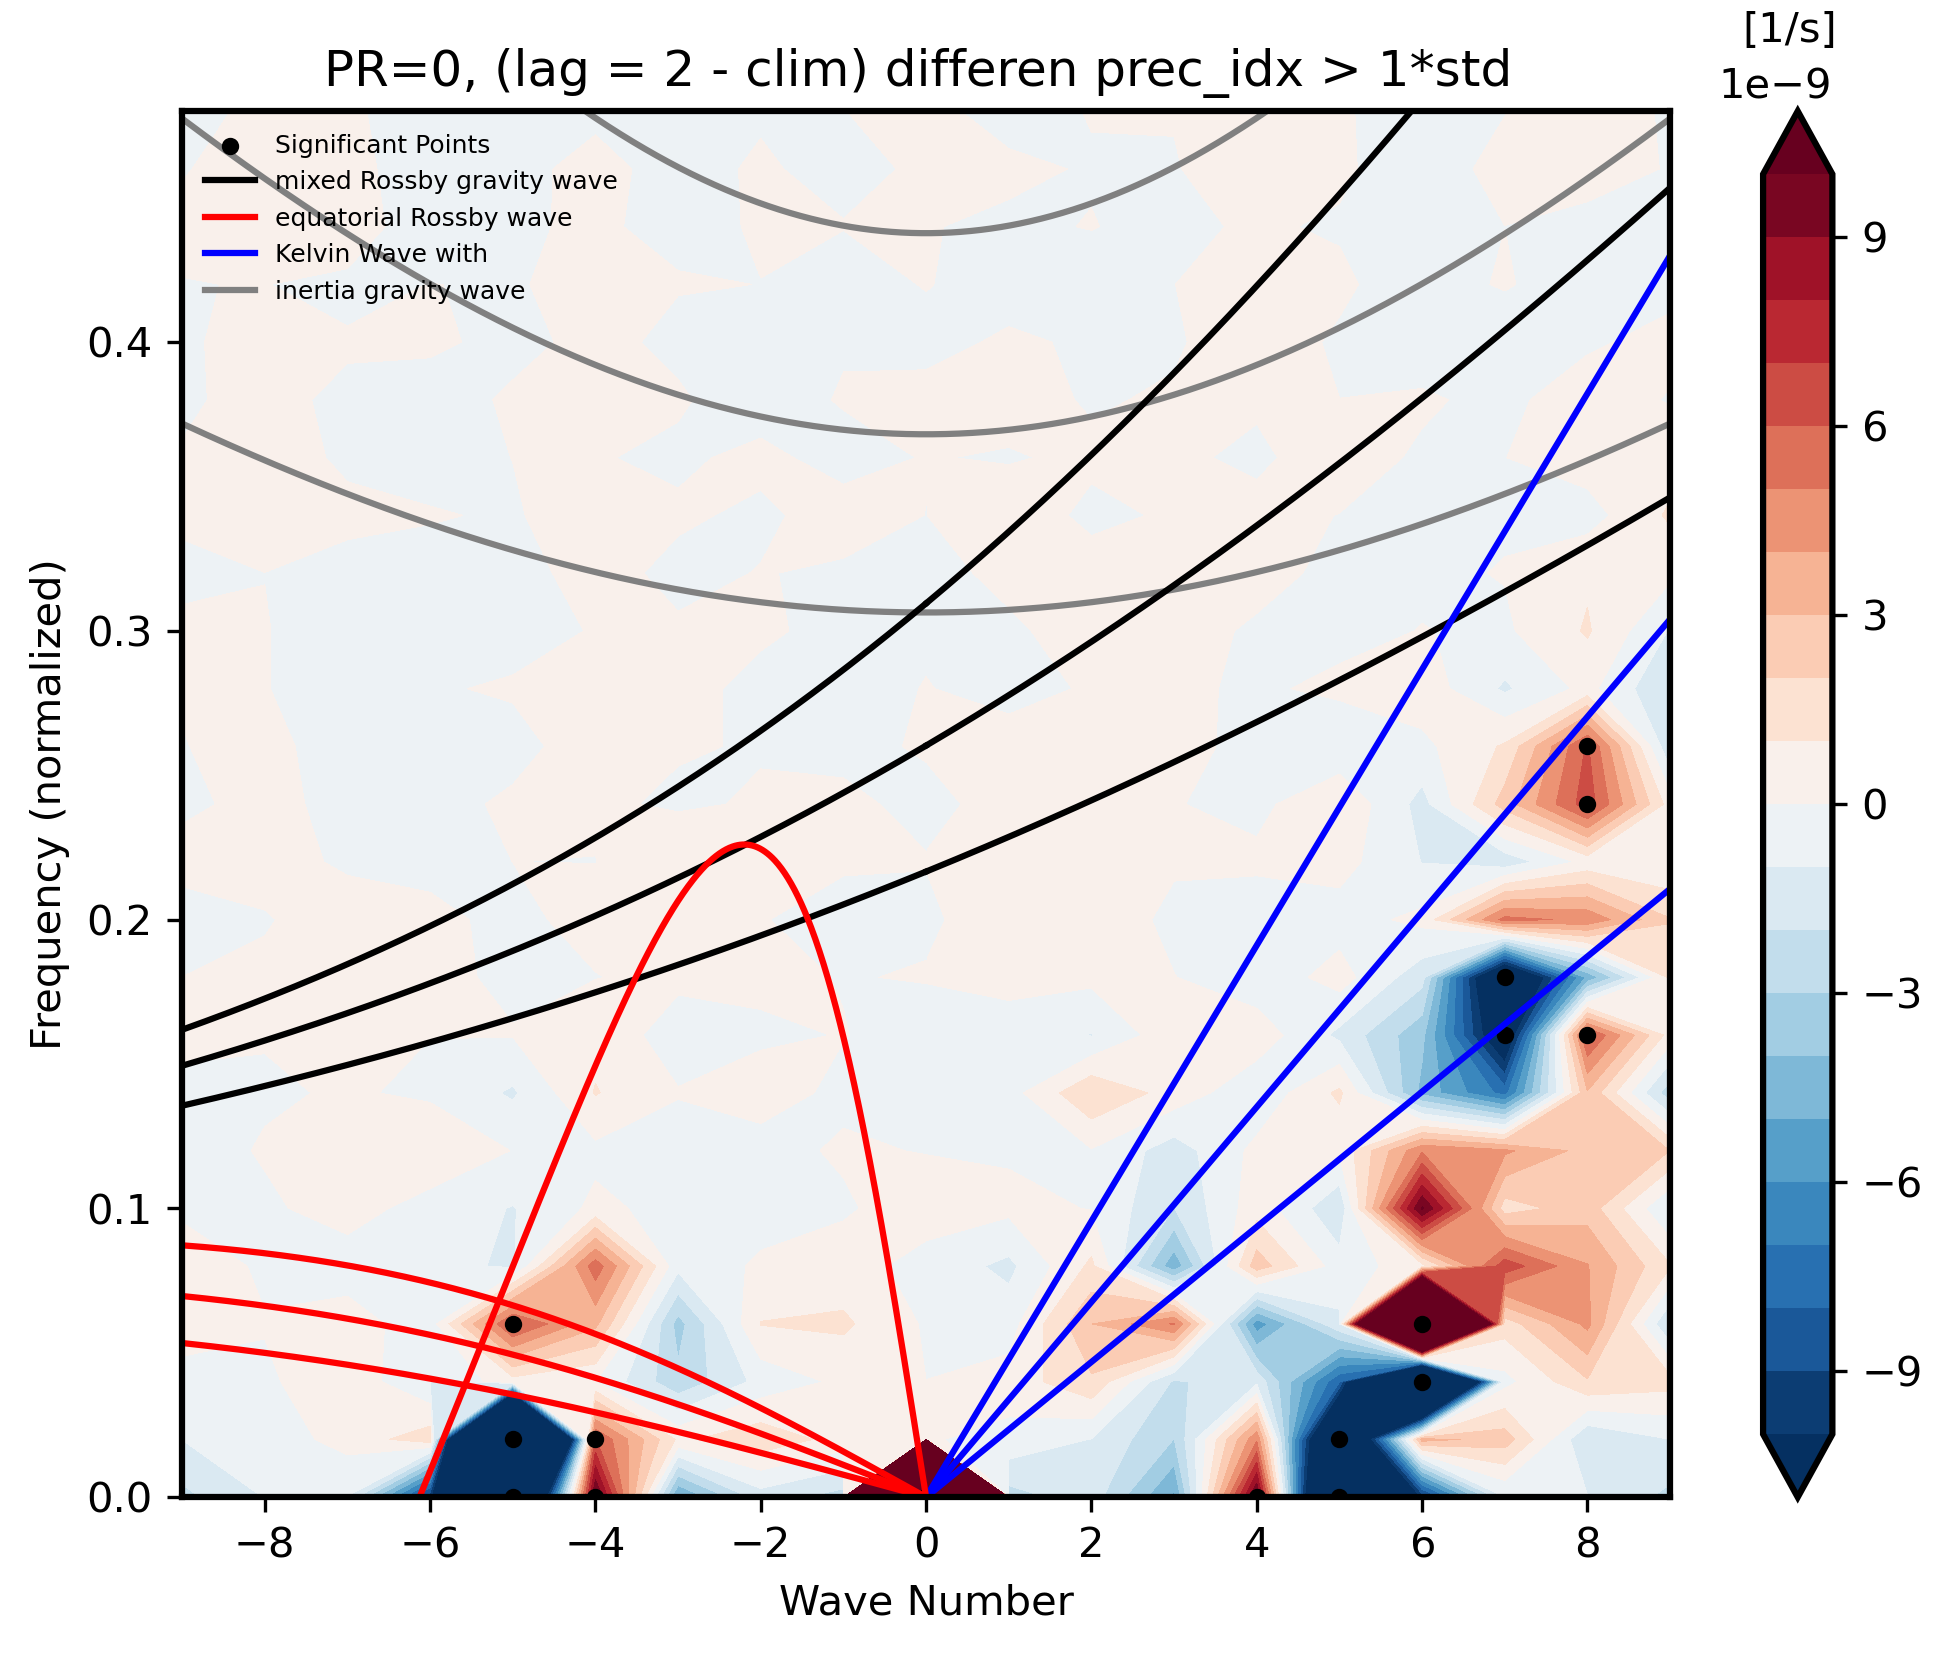

In [25]:
PR = 0
# Calculate the threshold for significance
east_lower_threshold_0 = np.percentile(random_differences_east_0, alpha * 100, axis=2)  # Lower 5%
east_upper_threshold_0 = np.percentile(random_differences_east_0, (1 - alpha) * 100, axis=2)  # Upper 95%

west_lower_threshold_0 = np.percentile(random_differences_west_0, alpha * 100, axis=2)  # Lower 5%
west_upper_threshold_0 = np.percentile(random_differences_west_0, (1 - alpha) * 100, axis=2)  # Upper 95%

##########################################################################################
significance_mask_east_0 = (differences_east_0 < east_lower_threshold_0) | (differences_east_0 > east_upper_threshold_0)
significance_mask_west_0 = (differences_west_0 < west_lower_threshold_0) | (differences_west_0 > west_upper_threshold_0)

min_effect_size = 6e-9  # Define a minimum physical significance threshold
significance_mask_east_0 = significance_mask_east_0 & (np.abs(differences_east_0) > min_effect_size)
significance_mask_west_0 = significance_mask_west_0 & (np.abs(differences_west_0) > min_effect_size)

plt.figure(figsize=(8,6), dpi=300.)

# Plot for east
cs = plt.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
CB = plt.colorbar(cs, label="Difference")
CB.set_label("[1/s]", labelpad=-32, y=1.13, rotation=0)

# Plot for west
cs = plt.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)

##################################################################################
# Scatter
# Scatter dots on statistically significant regions for west
significant_indices_west_0 = np.where(significance_mask_west_0)
plt.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0]) / 50,
    color='Black',
    s=10,
    # label='Significant Points (West)',
)


significant_indices_east_0 = np.where(significance_mask_east_0)
plt.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0]) / 50,
    color='Black', 
    s=10, 
    label='Significant Points',
)
##################################################################################
making_theoretical_line()

plt.xlim([-9, 9])
plt.ylim([0, 24 / 50])
plt.title(f"PR={PR}, (lag = {lag} - clim) differen prec_idx > 1*std ")
plt.xlabel("Wave Number")
plt.ylabel("Frequency (normalized)")
plt.show()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy import stats

# Statistical test for differences between lag = 2 and lag = 0
PR = 50
alpha = 0.01    # Significance level

# Calculate differences
differences_east_50 = m_final_positive_idx_lag5_50 - m_final_clim_idx_50
differences_west_50 = m_final_west_positive_idx_lag5_50 - m_final_clim_west_positive_idx_50

# Calculate random differences
import random
from scipy.stats import ttest_1samp
##########################################################################################
random_count = 5000
random_differences_east_50 = np.zeros((10,25,random_count))
random_differences_west_50 = np.zeros((10,25,random_count))

for i in range(random_count):
    # randomly select - clim
    random_lag_day_50 = np.asarray(np.random.choice(range(0, 19500), size=idx_50.shape[0], replace=True)) #random_numbers+lag
    random_m_final_positive_idx_lag5_50      = m_final_50[:,:,random_lag_day_50]#.mean(axis=2)
    random_m_final_west_positive_idx_lag5_50 = m_final_west_50[:,:,random_lag_day_50]#.mean(axis=2)    
    
    random_differences_east_50[:,:,i] = (random_m_final_positive_idx_lag5_50.mean(axis=2) - m_final_clim_idx_50[:,:])
    random_differences_west_50[:,:,i] = (random_m_final_west_positive_idx_lag5_50.mean(axis=2) - m_final_clim_west_positive_idx_50[:,:])

print("Randomly select done!")

Randomly select done!


[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


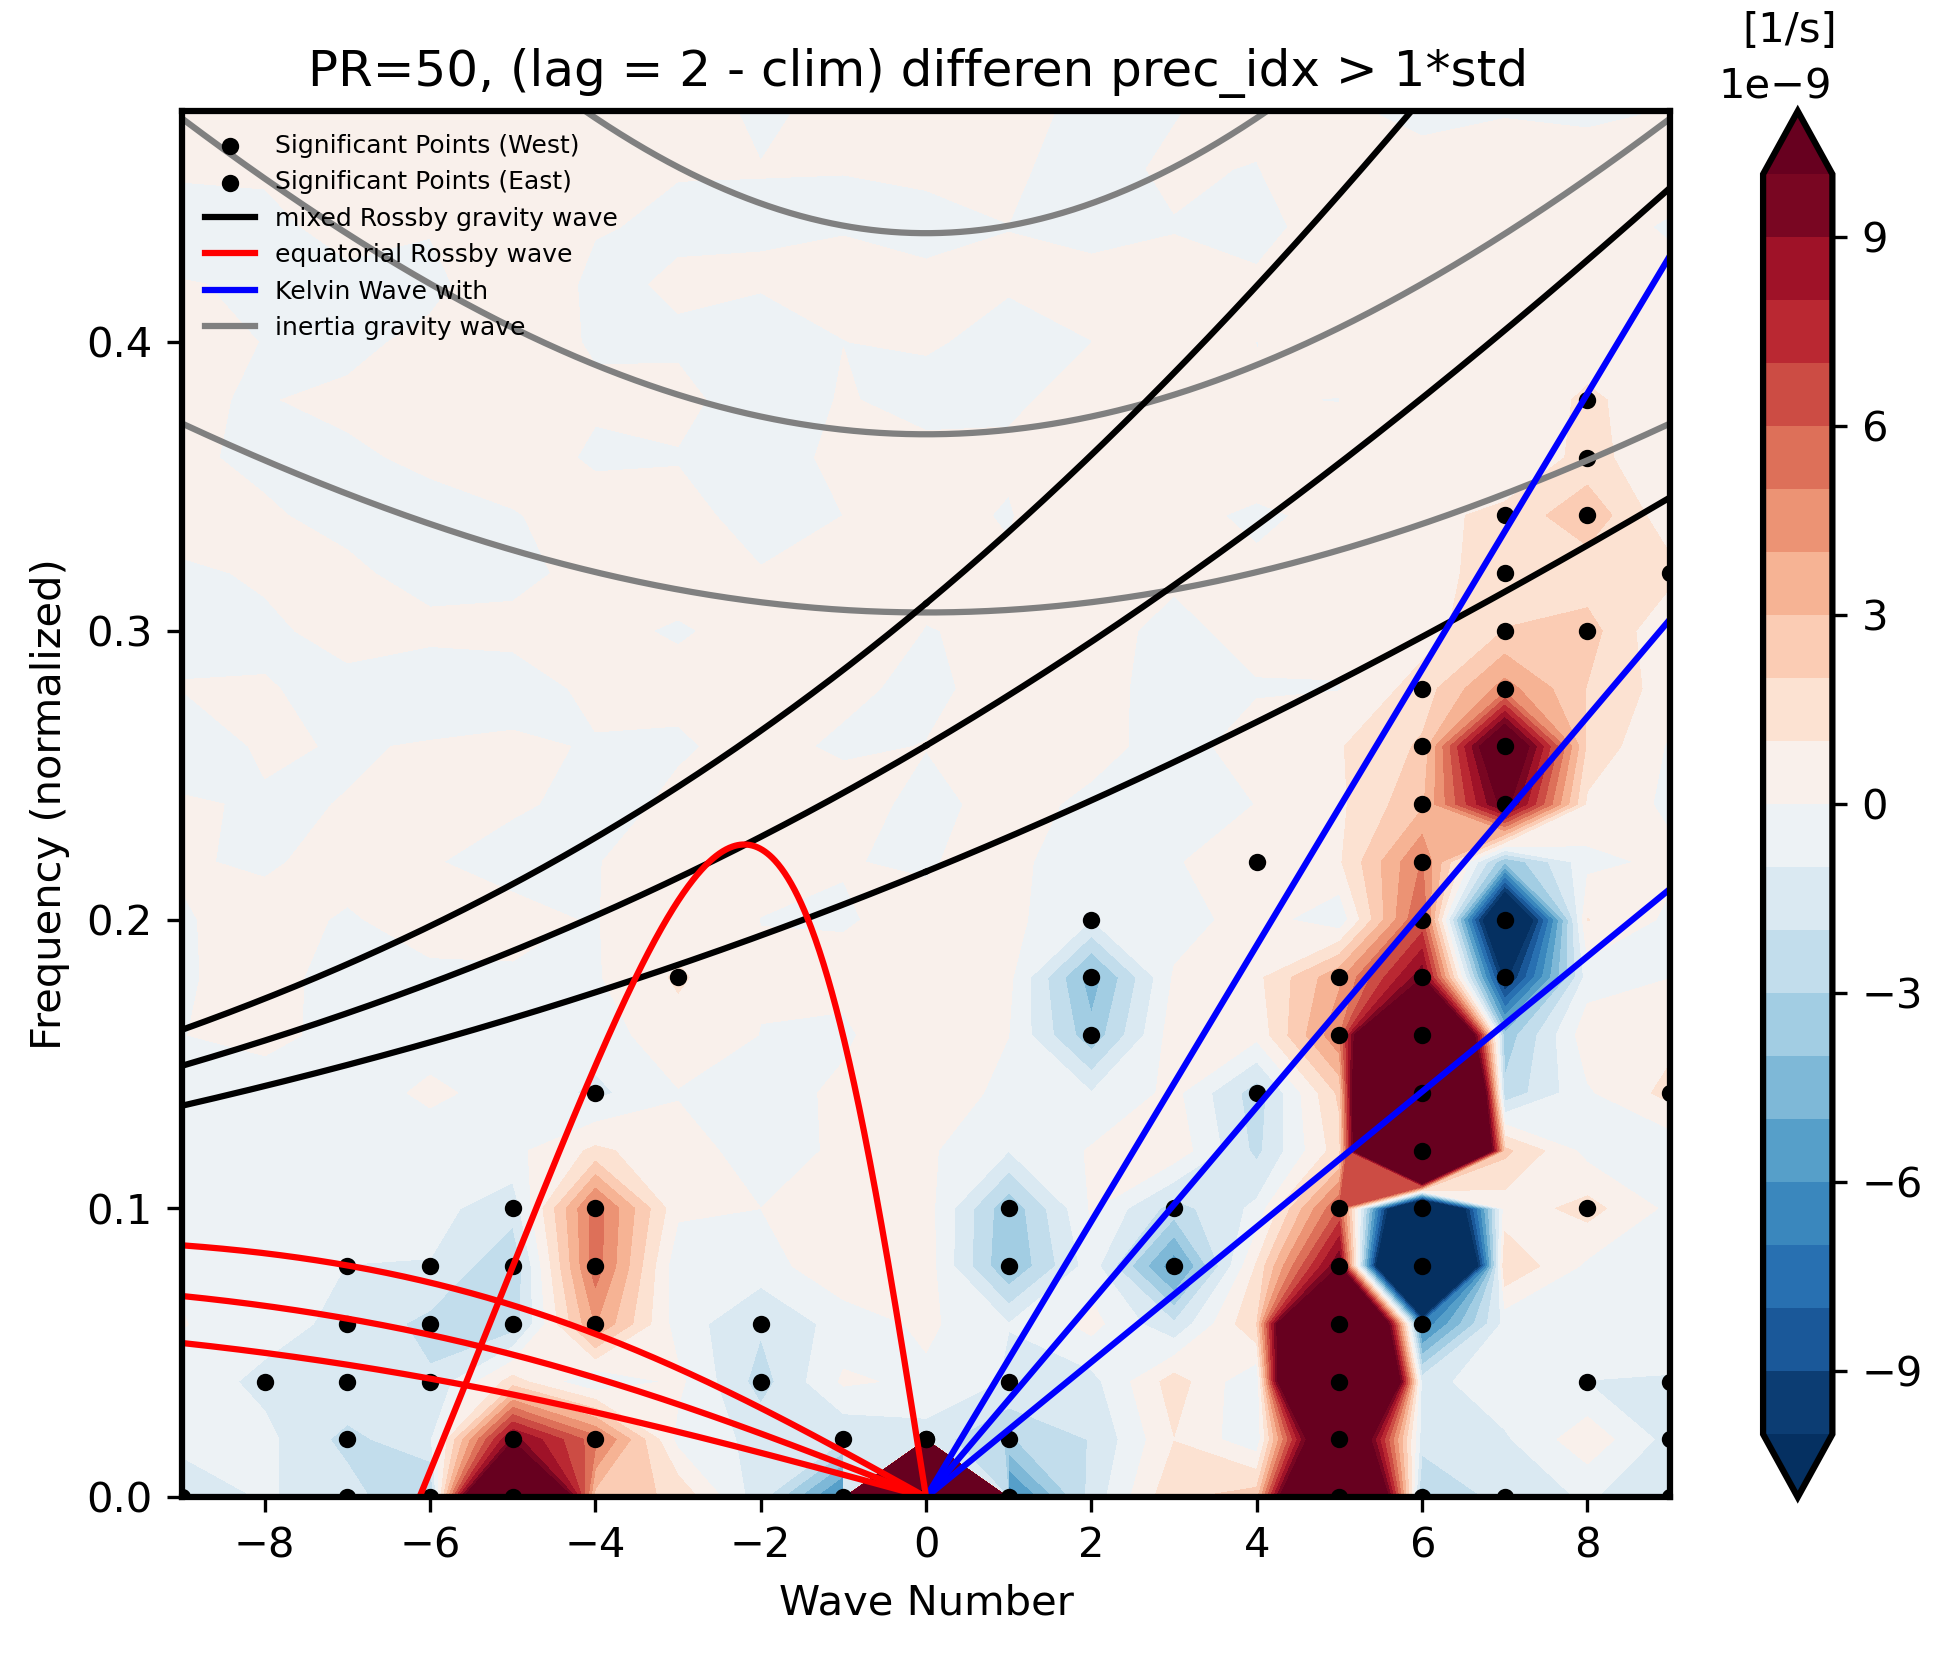

In [27]:
PR = 50
# Calculate the threshold for significance
east_lower_threshold_50 = np.percentile(random_differences_east_50, alpha * 100, axis=2)  # Lower 5%
east_upper_threshold_50 = np.percentile(random_differences_east_50, (1 - alpha) * 100, axis=2)  # Upper 95%

west_lower_threshold_50 = np.percentile(random_differences_west_50, alpha * 100, axis=2)  # Lower 5%
west_upper_threshold_50 = np.percentile(random_differences_west_50, (1 - alpha) * 100, axis=2)  # Upper 95%

##########################################################################################
significance_mask_east_50 = (differences_east_50 < east_lower_threshold_50) | (differences_east_50 > east_upper_threshold_50)
significance_mask_west_50 = (differences_west_50 < west_lower_threshold_50) | (differences_west_50 > west_upper_threshold_50)

min_effect_size = 1e-9  # Define a minimum physical significance threshold
significance_mask_east_50 = significance_mask_east_50 & (np.abs(differences_east_50) > min_effect_size)
significance_mask_west_50 = significance_mask_west_50 & (np.abs(differences_west_50) > min_effect_size)


plt.figure(figsize=(8,6), dpi=300.)
# Plot for east
##############################
# Mask the differences using a masked array instead of flattening
# significant_indices_east_50 = np.where(significance_mask_east_50)
# masked_differences_east_50 = np.ma.masked_where(~significance_mask_east_50, differences_east_50)

##############################
cs = plt.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    # masked_differences_east_50,
    differences_east_50,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
CB = plt.colorbar(cs, label="Difference")
CB.set_label("[1/s]", labelpad=-32, y=1.13, rotation=0)

# Plot for west
cs = plt.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_50,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)

##################################################################################
# Scatter
# Scatter dots on statistically significant regions for west
significant_indices_west_50 = np.where(significance_mask_west_50)
plt.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50]) / 50,
    color='Black',
    s=10,
    label='Significant Points (West)',
)


significant_indices_east_50 = np.where(significance_mask_east_50)
plt.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50]) / 50,
    color='Black', 
    s=10, 
    label='Significant Points (East)',
)
##################################################################################

making_theoretical_line()

plt.xlim([-9, 9])
plt.ylim([0, 24 / 50])
plt.title(f"PR={PR}, (lag = {lag} - clim) differen prec_idx > 1*std ")
plt.xlabel("Wave Number")
plt.ylabel("Frequency (normalized)")
plt.show()

In [28]:
print(np.shape(    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
              ))

(10, 25)


In [29]:
kkkkk = 0
wwwww = 12
plt.figure()
plt.hist(random_differences_west[kkkkk,wwwww,:])
plt.vlines(x = west_lower_threshold[kkkkk,wwwww], ymin=0, ymax=3000, color="Green")
plt.vlines(x = west_upper_threshold[kkkkk,wwwww], ymin=0, ymax=3000, color="Green")
plt.vlines(x = differences_west[kkkkk,wwwww], ymin=0, ymax=3000, color="Red")

NameError: name 'random_differences_west' is not defined

<Figure size 640x480 with 0 Axes>

In [30]:
test_idx = np.random.choice(range(0, 25), size=1)
print(test_idx)
plt.figure()
plt.plot(east_upper_threshold[:,test_idx[0]], label="upper_threshold")
plt.plot(differences_east[:,test_idx[0]], label="data")
plt.plot(east_lower_threshold[:,test_idx[0]], label="lower_threshold")
plt.legend()

test_idx = np.random.choice(range(0, 10), size=1)
print(test_idx)
plt.figure()
plt.plot(west_upper_threshold[test_idx[0],:], label="upper_threshold")
plt.plot(differences_west[test_idx[0],:], label="data")
plt.plot(west_lower_threshold[test_idx[0],:], label="lower_threshold")
plt.legend()

[20]


NameError: name 'east_upper_threshold' is not defined

<Figure size 640x480 with 0 Axes>

## Statistical figure 2

[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


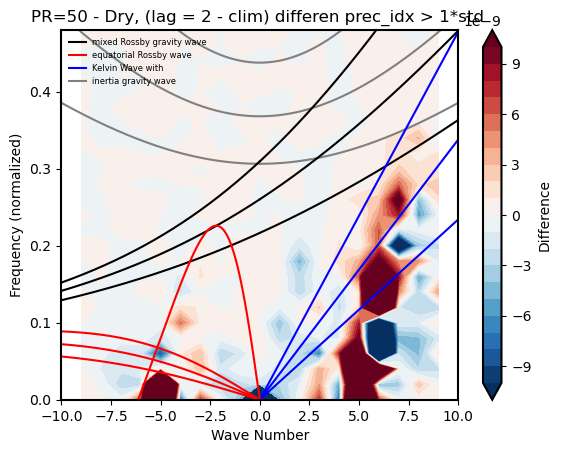

In [31]:
# Plot for east
cs = plt.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_50 - differences_east_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
plt.colorbar(cs, label="Difference")


# Plot for west
cs = plt.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_50 - differences_west_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)

making_theoretical_line()

plt.xlim([-10, 10])
plt.ylim([0, 24 / 50])
plt.title(f"PR={PR} - Dry, (lag = {lag} - clim) differen prec_idx > 1*std ")
plt.xlabel("Wave Number")
plt.ylabel("Frequency (normalized)")
plt.show()




In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
from scipy import stats

# Statistical test for differences between lag = 2 and lag = 0
alpha = 0.025     # Significance level

# Calculate random differences
import random
from scipy.stats import ttest_1samp
##########################################################################################
random_count = 5000
random_differences_east_mix_0 = np.zeros((10,25,random_count))
random_differences_west_mix_0 = np.zeros((10,25,random_count))

random_differences_east_mix_50 = np.zeros((10,25,random_count))
random_differences_west_mix_50 = np.zeros((10,25,random_count))

# Make random pool
m_final_mix      = np.concatenate((m_final_0, m_final_50), axis=2)
m_final_west_mix = np.concatenate((m_final_west_0, m_final_west_50), axis=2)

# Make mix clim mean
m_final_clim_idx_mix               = (m_final_clim_idx_0               + m_final_clim_idx_50              ) / 2 
m_final_clim_west_positive_idx_mix = (m_final_clim_west_positive_idx_0 + m_final_clim_west_positive_idx_50) / 2 

for i in range(random_count):
    # randomly select - clim
    random_lag_day_mix_0 = np.asarray(np.random.choice(range(0, 19500*2), size=(idx_0.shape[0]), replace=True)) #random_numbers+lag

    random_m_final_positive_idx_lag5_mix      = m_final_mix[:,:,random_lag_day_mix_0]#.mean(axis=2)
    random_m_final_west_positive_idx_lag5_mix = m_final_west_mix[:,:,random_lag_day_mix_0]#.mean(axis=2)    
    
    random_differences_east_mix_0[:,:,i] = (random_m_final_positive_idx_lag5_mix.mean(axis=2) - m_final_clim_idx_mix[:,:])
    random_differences_west_mix_0[:,:,i] = (random_m_final_west_positive_idx_lag5_mix.mean(axis=2) - m_final_clim_west_positive_idx_mix[:,:])
    ######################################################################################################
    random_lag_day_mix_50 = np.asarray(np.random.choice(range(0, 19500*2), size=(idx_50.shape[0]), replace=True)) #random_numbers+lag

    random_m_final_positive_idx_lag5_mix      = m_final_mix[:,:,random_lag_day_mix_50]#.mean(axis=2)
    random_m_final_west_positive_idx_lag5_mix = m_final_west_mix[:,:,random_lag_day_mix_50]#.mean(axis=2)    
    
    random_differences_east_mix_50[:,:,i] = (random_m_final_positive_idx_lag5_mix.mean(axis=2) - m_final_clim_idx_mix[:,:])
    random_differences_west_mix_50[:,:,i] = (random_m_final_west_positive_idx_lag5_mix.mean(axis=2) - m_final_clim_west_positive_idx_mix[:,:])


print("Randomly select done!")

Randomly select done!


(array([0, 0, 1, 1, 1, 2, 3, 3, 4, 4, 5, 5]), array([0, 1, 0, 1, 3, 3, 0, 8, 0, 5, 0, 1]))
[-3.74605632e-14  1.25526323e-03  2.51052647e-03 ...  1.75485800e+00
  1.75611326e+00  1.75736853e+00]
[-3.11806103e-14  1.04482876e-03  2.08965752e-03 ...  1.46067060e+00
  1.46171543e+00  1.46276026e+00]
[-2.62196635e-14  8.78592757e-04  1.75718551e-03 ...  1.22827267e+00
  1.22915127e+00  1.23002986e+00]
313.04951684997053


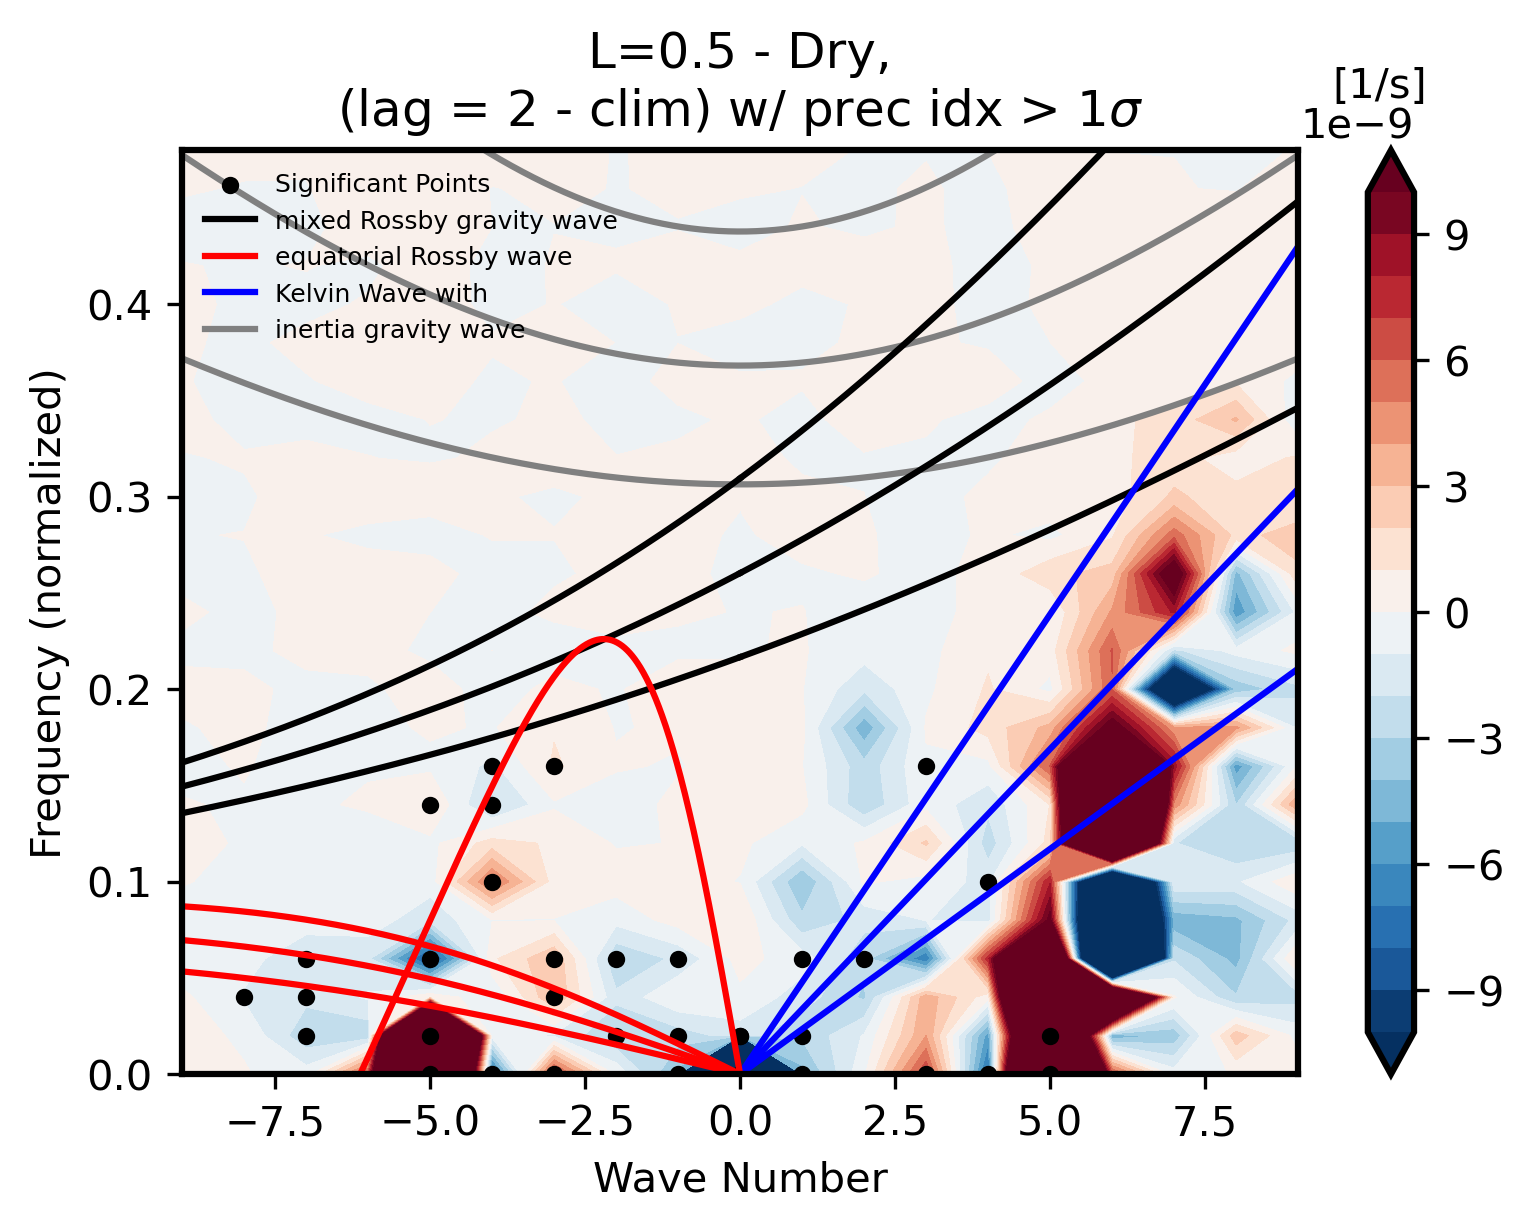

In [33]:
# Calculate the threshold for significance
east_lower_threshold_mix = np.percentile((random_differences_east_mix_50 - random_differences_east_mix_0), alpha * 100, axis=2)  # Lower 5%
east_upper_threshold_mix = np.percentile((random_differences_east_mix_50 - random_differences_east_mix_0), (1 - alpha) * 100, axis=2)  # Upper 95%

west_lower_threshold_mix = np.percentile((random_differences_west_mix_50 - random_differences_west_mix_0), alpha * 100, axis=2)  # Lower 5%
west_upper_threshold_mix = np.percentile((random_differences_west_mix_50 - random_differences_west_mix_0), (1 - alpha) * 100, axis=2)  # Upper 95%

##########################################################################################
significance_mask_east_mix = ((differences_west_50 - differences_west_0) < east_lower_threshold_mix) | ((differences_west_50 - differences_west_0) > east_upper_threshold_mix)
significance_mask_west_mix = ((differences_west_50 - differences_west_0) < west_lower_threshold_mix) | ((differences_west_50 - differences_west_0) > west_upper_threshold_mix)

min_effect_size = 1e-9  # Define a minimum physical significance threshold
significance_mask_east_mix = significance_mask_east_mix & (np.abs(differences_west_50 - differences_west_0) > min_effect_size)
significance_mask_west_mix = significance_mask_west_mix & (np.abs(differences_west_50 - differences_west_0) > min_effect_size)

plt.figure(figsize=(6,4), dpi=300.)

# Plot for east
cs = plt.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_50 - differences_east_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
CB = plt.colorbar(cs, label="Difference")
CB.set_label("[1/s]", labelpad=-30, y=1.15, rotation=0)



# Plot for west
cs = plt.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_50 - differences_west_0,
    levels=np.linspace(-1E-8, 1E-8, 21),
    extend="both",
    cmap="RdBu_r",
)

##################################################################################
# Scatter
# Scatter dots on statistically significant regions for west
significant_indices_west = np.where(significance_mask_west_mix)
plt.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west]) / 50,
    color='Black',
    s=10,
    # label='Significant Points (West)',
)


significant_indices_east = np.where(significance_mask_east_mix)
print(significant_indices_east)
plt.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east]) / 50,
    color='Black', 
    s=10, 
    label='Significant Points',
)
##################################################################################
making_theoretical_line()
plt.xlim([-9, 9])
plt.ylim([0, 24 / 50])
plt.title(f"L={PR*0.01} - Dry,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$ ")
plt.xlabel("Wave Number")
plt.ylabel("Frequency (normalized)")
plt.show()

In [691]:
idx_0.shape[0], idx_50.shape[0]

(3028, 3080)

In [693]:
m_final_0.shape[0], m_final_50.shape[0]

(10, 10)

In [711]:
hi = np.stack((m_final_0, m_final_50), axis=3)
hi.shape

(10, 25, 19500, 2)

In [713]:
m_final_stacked.shape

(10, 25, 39000)

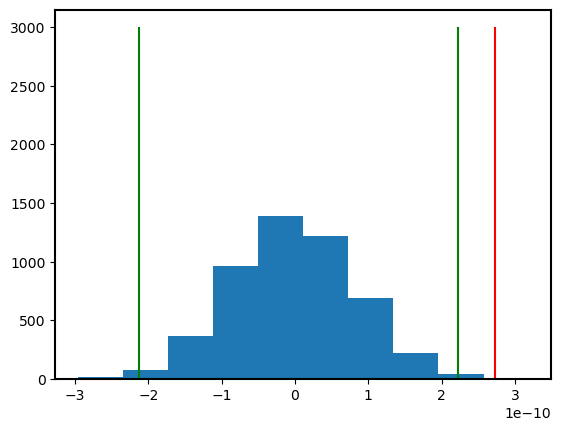

In [742]:
kkkkk = 0
wwwww = 12
plt.figure()
plt.hist((random_differences_west_mix_50 - random_differences_west_mix_0)[kkkkk,wwwww,:])
plt.vlines(x = west_lower_threshold[kkkkk,wwwww], ymin=0, ymax=3000, color="Green")
plt.vlines(x = west_upper_threshold[kkkkk,wwwww], ymin=0, ymax=3000, color="Green")
plt.vlines(x = (differences_west_50 - differences_west_0)[kkkkk,wwwww], ymin=0, ymax=3000, color="Red")

# Concentrate three figures

In [35]:
def making_theoretical_line_subplot(ax, show_legend):
    beta = 2.289*10**(-11)

    for h in [12,25,50]: # equivalent depth
        c  = np.sqrt(9.8*h)
        #c    = 50
        
        # Define the wave number array
        k = np.arange(-14, 14.01, 0.01)/(6371*10**3)
        K_size = np.size(k)
        K_size_half = int((K_size-1)/2)
        
        # Calculate omega1 and omega2
        omega1 = np.zeros(K_size)
        omega2 = np.zeros(K_size)
        for i in range(K_size):
            omega1[i] = k[i]*c / 2 * (1 + (1 + 4*beta*c/(k[i] ** 2*c**2)) ** 0.5)
            omega2[i] = k[i]*c / 2 * (1 - (1 + 4*beta*c/(k[i] ** 2*c**2)) ** 0.5)
        
        # Calculate omega3, omega4, and omega5
        omega3 = np.zeros(K_size)
        omega4 = np.zeros(K_size)
        omega5 = np.zeros(K_size)
        for i in range(K_size):
            omega3[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
            omega4[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
            omega5[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)
        
        # Calculate omega6, omega7, and omega8
        omega6 = np.sqrt(2*beta*c + k ** 2*c**2)
        omega7 = np.sqrt(3*beta*c + k ** 2*c**2)
        omega8 = np.sqrt(4*beta*c + k ** 2*c**2)
    
        # Calculate Kelvin
        Omega_Kelvin = k*c
        
        k = np.arange(-14, 14.01, 0.01)
        # Plot the result
        ax.plot(k[K_size_half+1:], omega1[K_size_half+1:]*86400/(2*np.pi), 'k', label='mixed Rossby gravity wave'if h == 12 else None)
        ax.plot(k[0:K_size_half],  omega2[0:K_size_half]*86400/(2*np.pi),  'k')
        ax.plot(k[0:K_size_half],  omega3[0:K_size_half]*86400/(2*np.pi),  'r-',label='equatorial Rossby wave'if h == 12 else None)
        # plt.plot(k[0:300], omega4[0:300]*86400/(2*np.pi), 'r-.',label='equatorial rossby wave n=2')
        # plt.plot(k[0:300], omega5[0:300]*86400/(2*np.pi), 'r',label='equatorial rossby wave n=3')
        ax.plot(k[K_size_half:], k[K_size_half:]*c/(6371*10**3)*86400/(2*np.pi), 'b-', label='Kelvin Wave with'if h == 12 else None)
        #plt.plot(k[K_size_half:], k[K_size_half:]*c/(6371*10**3), 'b-', label='Kelvin Wave with k=w')
        # print(k[K_size_half:]/np.sqrt(c/beta)*86400)
        ax.plot(k, omega6*86400/(2*np.pi), color='gray',label='inertia gravity wave'if h == 12 else None)
        # plt.plot(k[0:601], omega7[0:601], 'b-.',label='inertia gravity wave n=2')
        # plt.plot(k[0:601], omega8[0:601], 'b',label='inertia gravity wave n=3')



    for h in [10000]: # equivalent depth
        omega3  = np.zeros(K_size)
        c       = np.sqrt(9.8*h)
        k       = np.arange(-14, 14.01, 0.01)/(6371*10**3)
        for i in range(K_size):
            omega3[i] = -k[i]*beta / (k[i] ** 2 + 3*beta/c)+30*k[i]
        k = np.arange(-14, 14.01, 0.01)
        ax.plot(k[0:K_size_half],  omega3[0:K_size_half]*86400/(2*np.pi),  'r--',label='Rossby Haurwitz')

    # Show legend
    if show_legend:
        ax.legend(
            loc="upper left",
            prop={"size": 12},
            frameon=True,
            ncols=1,
        )
        
    
    ax.set_ylim([0,0.8])


/tmp/ipykernel_2431459/783693673.py:173: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


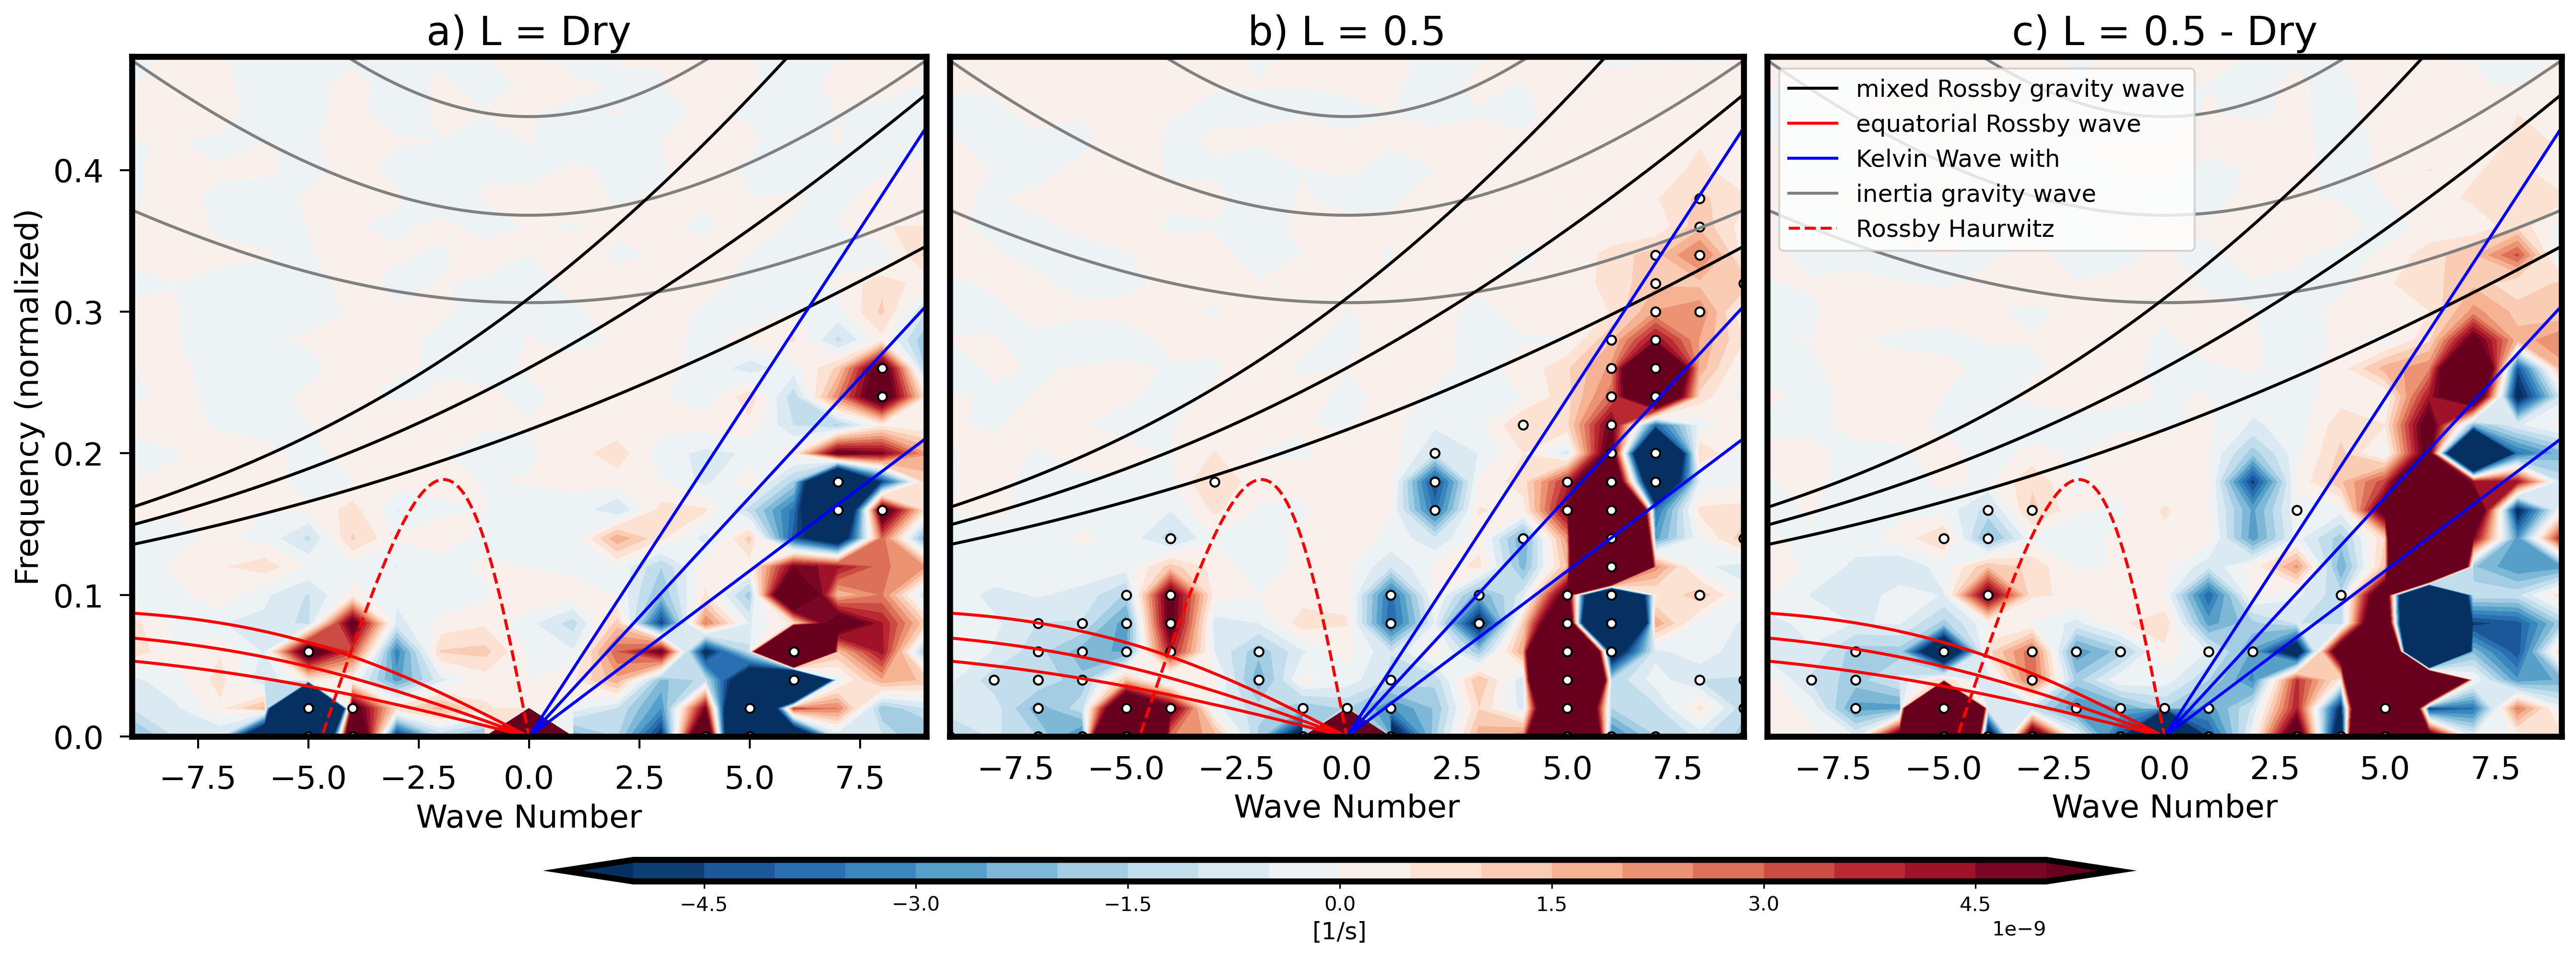

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set up the figure and subplots

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=300)
mpl.rcParams['axes.linewidth'] = 3


# Subplot 1: PR=0
ax1 = axes[0]
making_theoretical_line_subplot(ax1, False)
cs1_east = ax1.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
cs1_west = ax1.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
# CB1 = fig.colorbar(cs1_east, ax=ax1, orientation='vertical')
# CB1.set_label("[1/s]", labelpad=-32, y=1.05, rotation=0)

# Scatter for east
significant_indices_east_0 = np.where(significance_mask_east_0)
ax1.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0]) / 50,
    color='White',
    edgecolors='Black',
    s=20, 
)

# Scatter for west
significant_indices_west_0 = np.where(significance_mask_west_0)
ax1.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0]) / 50,
    color='White',
    edgecolors='Black',
    s=20,
)




# Subplot 2: PR=50
ax2 = axes[1]
making_theoretical_line_subplot(ax2, False)
cs2_east = ax2.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_50,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
cs2_west = ax2.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_50,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
# CB2 = fig.colorbar(cs2_east, ax=ax2, orientation='vertical')
# CB2.set_label("[1/s]", labelpad=-32, y=1.05, rotation=0)

# Scatter for east
significant_indices_east_50 = np.where(significance_mask_east_50)
ax2.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50]) / 50,
    color='White',
    edgecolors='Black', 
    s=20, 
)

# Scatter for west
significant_indices_west_50 = np.where(significance_mask_west_50)
ax2.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50]) / 50,
    color='White',
    edgecolors='Black',
    s=20,
)

# Subplot 3: PR=50 - PR=0
ax3 = axes[2]
making_theoretical_line_subplot(ax3, True)

cs3_east = ax3.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_50 - differences_east_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
cs3_west = ax3.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T/ 50,
    differences_west_50 - differences_west_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)


# Scatter for east
significant_indices_east_mix = np.where(significance_mask_east_mix)
ax3.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_mix], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_mix]) / 50,
    color='White',
    edgecolors='Black',
    s=20, 
)

# Scatter for west
significant_indices_west_mix = np.where(significance_mask_west_mix)
ax3.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_mix],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_mix]) / 50,
    color='White',
    edgecolors='Black',
    s=20,
)

# title
# ax1.set_title(f"L = Dry,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)
# ax2.set_title(f"L = 0.5,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)
# ax3.set_title(f"L = 0.5 - Dry,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)

ax1.set_title(f"a) L = Dry", fontsize=20)
ax2.set_title(f"b) L = 0.5", fontsize=20)
ax3.set_title(f"c) L = 0.5 - Dry", fontsize=20)


for i in range(3):
    axes[i].tick_params(axis="x", labelsize=16, pad=8)
    axes[i].tick_params(axis="y", labelsize=16, pad=8)
    axes[i].set_xlabel("Wave Number", fontsize=16)
    axes[i].set_xlim([-9, 9])
    axes[i].set_ylim([0, 24 / 50])
    if i ==0:
        axes[i].tick_params(direction="out", length=6, width=1)
    
    # Remove y-ticks for ax[1] and ax[2]
    if i > 0:
        axes[i].set_yticklabels([])
        axes[i].tick_params(direction="out", length=1, width=0.5)


axes[0].set_ylabel("Frequency (normalized)", fontsize=16)

# Adjust layout
cax=fig.add_axes([0.22,-0.03,0.6,0.025]) # (left, bottom, width, height)
CB3 = plt.colorbar(cs3_east, ax=axes, cax=cax, orientation='horizontal')
CB3.set_label("[1/s]", labelpad=3, y=-20, rotation=0, fontsize=12)
# plt.suptitle(f"\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=24)
# fig.subplots_adjust(top=0.75)  # Adjust the top margin to reduce space

plt.tight_layout()


# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

plt.savefig(r"/data92/PeterChang/paper1_fig/Fig7.png", bbox_inches='tight', dpi=300.)
plt.show()


In [252]:
# print(np.shape(significant_indices_east_0))
# print(differences_east_0.shape)
# print(differences_east_0[significant_indices_east_0].shape)
# significant_indices_west_0 = np.where(significance_mask_west_0)
print(np.shape(significance_mask_west_0))
print(np.shape(significant_indices_west_0))
print(significant_indices_west_0)

(10, 25)
(2, 6)
(array([0, 4, 4, 5, 5, 5]), array([0, 0, 1, 0, 1, 3]))


NameError: name 'mpl' is not defined

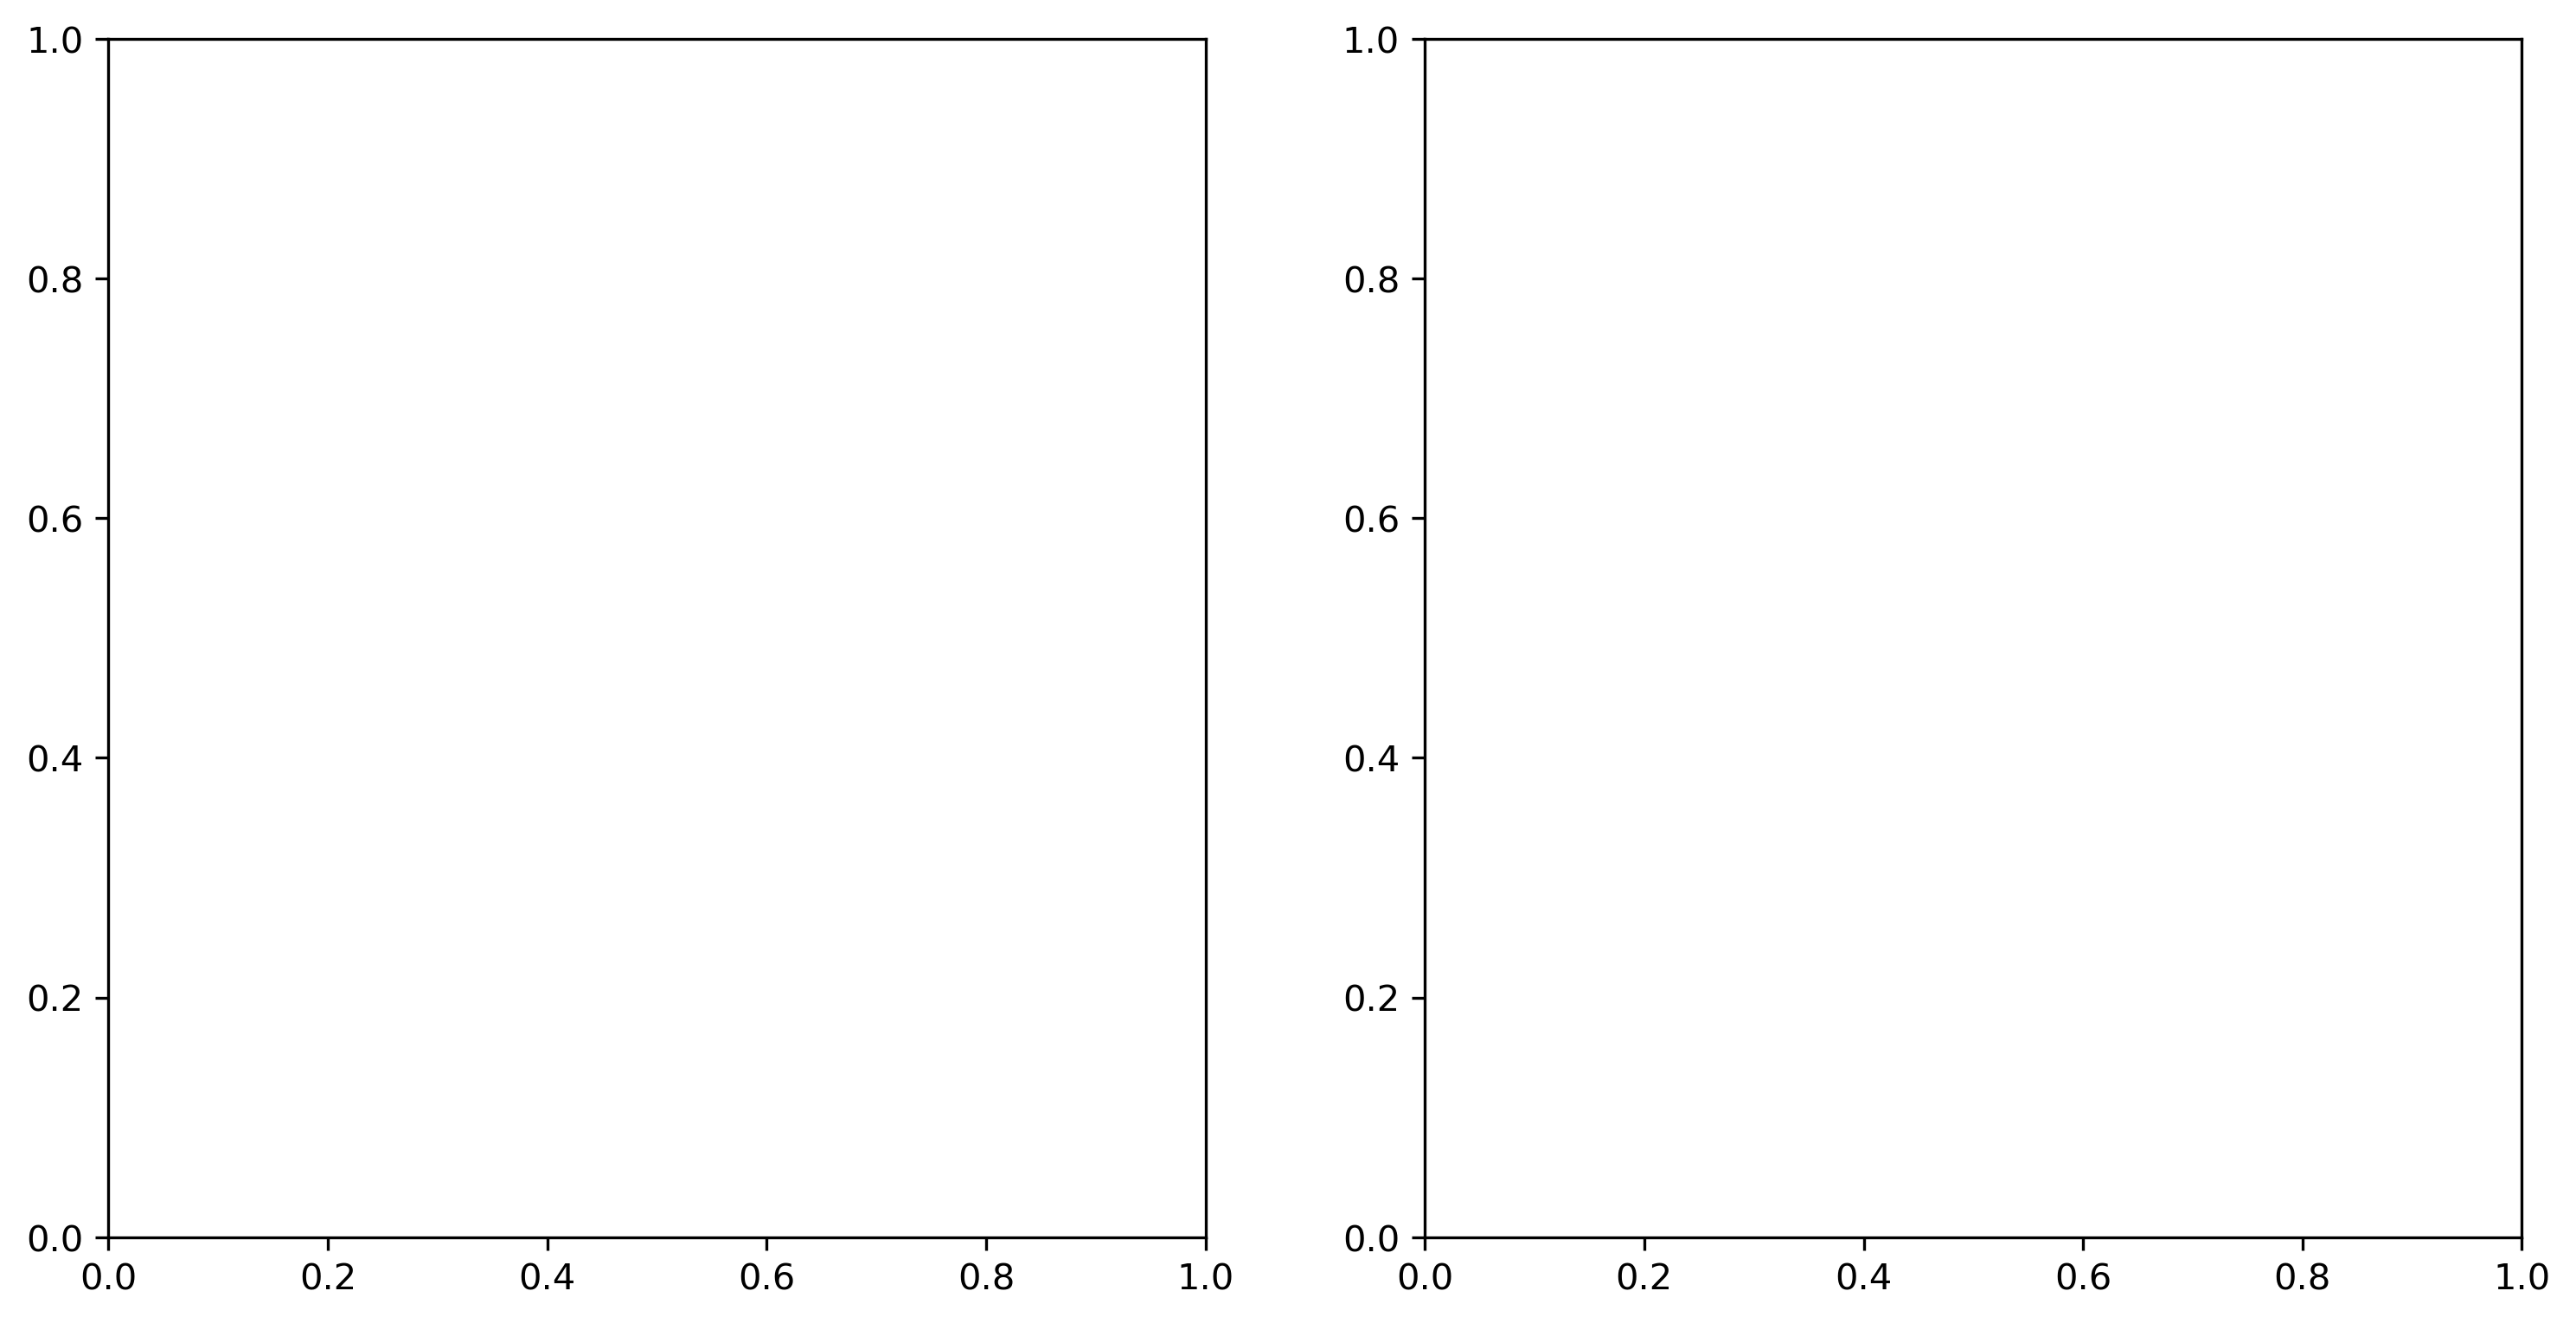

In [3]:
import matplotlib.pyplot as plt

# Set up the figure and subplots

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
mpl.rcParams['axes.linewidth'] = 3


# Subplot 1: PR=0
ax1 = axes[0]
making_theoretical_line_subplot(ax1, False)
cs1_east = ax1.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
cs1_west = ax1.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_0,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
# CB1 = fig.colorbar(cs1_east, ax=ax1, orientation='vertical')
# CB1.set_label("[1/s]", labelpad=-32, y=1.05, rotation=0)

# Scatter for east
significant_indices_east_0 = np.where(significance_mask_east_0)
ax1.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_0]) / 50,
    color='White',
    edgecolors='Black',
    s=10, 
)

# Scatter for west
significant_indices_west_0 = np.where(significance_mask_west_0)
ax1.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_0]) / 50,
    color='White',
    edgecolors='Black',
    s=10,
)




# Subplot 2: PR=50
ax2 = axes[1]
making_theoretical_line_subplot(ax2, True)
cs2_east = ax2.contourf(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_east_50,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
cs2_west = ax2.contourf(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
    w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
    differences_west_50,
    levels=np.linspace(-0.5E-8, 0.5E-8, 21),
    extend="both",
    cmap="RdBu_r",
)
# CB2 = fig.colorbar(cs2_east, ax=ax2, orientation='vertical')
# CB2.set_label("[1/s]", labelpad=-32, y=1.05, rotation=0)

# Scatter for east
significant_indices_east_50 = np.where(significance_mask_east_50)
ax2.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_50]) / 50,
    color='White',
    edgecolors='Black',
    s=10, 
)

# Scatter for west
significant_indices_west_50 = np.where(significance_mask_west_50)
ax2.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_50]) / 50,
    color='White',
    edgecolors='Black',
    s=10,
)

# Subplot 3: PR=50 - PR=0
# ax3 = axes[2]
# making_theoretical_line_subplot(ax3, True)

# cs3_east = ax3.contourf(
#     k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
#     w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
#     differences_east_50 - differences_east_0,
#     levels=np.linspace(-1E-8, 1E-8, 21),
#     extend="both",
#     cmap="RdBu_r",
# )
# cs3_west = ax3.contourf(
#     -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T,
#     w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T / 50,
#     differences_west_50 - differences_west_0,
#     levels=np.linspace(-1E-8, 1E-8, 21),
#     extend="both",
#     cmap="RdBu_r",
# )


# Scatter for east
significant_indices_east_mix = np.where(significance_mask_east_mix)
ax3.scatter(
    k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_mix], 
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_east_mix]) / 50,
    color='White',
    edgecolors='Black',
    s=10, 
)

# Scatter for west
significant_indices_west_mix = np.where(significance_mask_west_mix)
ax3.scatter(
    -k[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_mix],
    (w[int(index_of_frequency_sml):int(index_of_frequency_big+1), int(index_of_wave_number_sml):int(index_of_wave_number_big+1)].T[significant_indices_west_mix]) / 50,
    color='White',
    edgecolors='Black',
    s=10,
)

# title
# ax1.set_title(f"L = Dry,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)
# ax2.set_title(f"L = 0.5,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)
# ax3.set_title(f"L = 0.5 - Dry,\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=18)

ax1.set_title(f"L = Dry", fontsize=26, pad=8)
ax2.set_title(f"L = 0.5", fontsize=26, pad=8)
# ax3.set_title(f"L = 0.5 - Dry", fontsize=20)


for i in range(2):
    axes[i].tick_params(axis="x", labelsize=16, pad=8)
    axes[i].tick_params(axis="y", labelsize=16, pad=8)
    axes[i].set_xlabel("Wave Number", fontsize=16)
    axes[i].set_xlim([-9, 9])
    axes[i].set_ylim([0, 24 / 50])
    # if i ==0:
    axes[i].tick_params(direction="out", length=4, width=1)
    
    # Remove y-ticks for ax[1] and ax[2]
    if i > 0:
        axes[i].set_yticklabels([])
        # axes[i].tick_params(direction="out", length=6, width=1)


axes[0].set_ylabel("Frequency (normalized)", fontsize=16)

# Adjust layout
cax=fig.add_axes([0.22,-0.03,0.6,0.025]) # (left, bottom, width, height)
CB3 = plt.colorbar(cs2_east, ax=axes, cax=cax, orientation='horizontal')
CB3.set_label("[1/s]", labelpad=3, y=-20, rotation=0, fontsize=12)
# plt.suptitle(f"\n(lag = {lag} - clim) w/ prec idx > 1$\sigma$", fontsize=24)
# fig.subplots_adjust(top=0.75)  # Adjust the top margin to reduce space

plt.tight_layout()


# plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle

# plt.savefig(r"/data92/PeterChang/paper1_fig/Fig7_.png", bbox_inches='tight', dpi=300.)
plt.show()
